In [1]:
import torch
import pandas as pd
from torch import nn
from torchvision import transforms

from functools import partial

from collections import defaultdict



import re, math, sys
import numpy as np
import random

import os
from tqdm import tqdm

from PIL import Image
import importlib

from matplotlib import pyplot as plt

import cv2

import shap_functions

!pip install shap




DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.
  Using cached shap-0.41.0.tar.gz (380 kB)
  Installing build dependencies ... error
  ERROR: Command errored out with exit status 1:
   command: /Library/Frameworks/Python.framework/Versions/2.7/Resources/Python.app/Contents/MacOS/Python /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pip install --ignore-installed --no-user --prefix /private/var/folders/3l/2lt99jp97mvbvsj3_p5hh8f80000gn/T/pip-build-env-0Ex7oK/overlay --no-warn-script-location --no-binary :none: --only-binary :none: -i https://pypi.org/simple -- setuptools wheel oldest-supported-numpy
       cwd: None
  Compl

# Load data

In [45]:
MACHINE = "offline" # set to "offline" or "colab"

stimuli_df = None
import utils
importlib.reload(utils)
stimuli_df = utils.STIMULI_DF

# add an extra "../" tot he data paths to create ../../VALSE_data
stimuli_df['img_path'] = [os.path.join("..",path) for path in stimuli_df['img_path']]

stimuli_df.head(2)


# import entire VALSE but only relevant linguistic phenomena
all_valse_df = utils.ENTIRE_DATASET_DF
all_valse_df = all_valse_df[all_valse_df['linguistic_phenomena'].isin(['actions','relations','existence'])]

# create 'img_path' column which has correct path to all the img files of valse dataset
if MACHINE == "offline":
    all_valse_df['img_path'] = [os.path.join("../../VALSE_data/",path) for path in all_valse_df['local_img_path']]
if MACHINE == "colab": #if running on GOOGLE COLAB, all image fils are just at images/filename
    all_valse_df['img_path'] = [os.path.join("images", os.path.basename(path)) for path in all_valse_df['local_img_path']]

all_valse_df = all_valse_df.drop(['local_img_path'], axis=1)
all_valse_df.head(2)




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,dataset,dataset_idx,image_file,linguistic_phenomena,caption,answer,classes,split,original_split,classes_foil,...,nli_scores,key,declarative_statement,declarative_statement_foils,provenance_of_foils,foiling_method,orig_caption,only_caption,include_in_experiment,img_path
1000,coco2017,212732,000000462576.jpg,relations,Breakfast items including juice are on the table.,NaN,on,NaN,val,off,...,"{'entail': [0.014606113545596001], 'contradict...",relations:coco_2017:212732,NaN,NaN,NaN,NaN,NaN,NaN,True,../../VALSE_data/images/coco2017/000000462576.jpg
1001,coco2017,528685,000000294162.jpg,relations,The white laptop is turned off but left open.,NaN,off,NaN,val,on,...,"{'entail': [0.054079204797744], 'contradict': ...",relations:coco_2017:528685,NaN,NaN,NaN,NaN,NaN,NaN,True,../../VALSE_data/images/coco2017/000000294162.jpg


# Load model

Note: We are using an FRCNN that is loaded in the exact same way as VALSE. **FRCNN is used to preprocess the images** before feeding them into LXMERT

In [6]:
# model specific


# from transformers import CLIPProcessor, CLIPModel

# global model
# model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
# processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


model_name = "LXMERT"

# local imports
from VALSE_LXMERT_FILES.utils import Config, img_tensorize
from VALSE_LXMERT_FILES.processing_image import Preprocess
from VALSE_LXMERT_FILES.modeling_frcnn import GeneralizedRCNN

from transformers import LxmertTokenizer, LxmertForPreTraining
from PIL import Image
import requests

# load models and model components
frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg)
image_preprocess = Preprocess(frcnn_cfg)

lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")
lxmert_base = LxmertForPreTraining.from_pretrained("unc-nlp/lxmert-base-uncased")

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /Users/eduardsaakashvili/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


# Test model on a single example

### Load individual image

Caption: There is fruit.
Foil: There is no fruit.


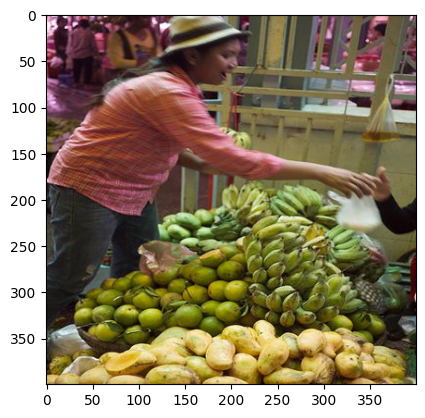

In [28]:
row = stimuli_df.iloc[1]
img_path, caption, foil = row['img_path'], row['caption'], row['foil']
image = Image.open(img_path).resize((400,400))

plt.imshow(image)
print(f"Caption: {caption}\nFoil: {foil}")

# Define model prediction functions

### Define preprocessing functions

In [13]:
def preprocess_text(caption, foil):

    test_sentences = [caption, foil]

    inputs = lxmert_tokenizer(
        test_sentences,
        padding="max_length",
        max_length=30,  # 20
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
        )
    
    return inputs


def img_preprocess_function(image_array):

    """Take RGB numpy  image, preprocess it, 
    then pass it to the FRCNN

    IMAGE MUST BE A NUMPY ARRAY or PIL IMAGE WITH 3 color channels like 224, 224, 3!!!

    # IF ONLY 1 COLOR CHANNEL THIS CAN FAIL!

    and return a preprocessed set of variables for LXMERT"""
    # preprocess  image

    # resize to 400x400 and convert to cv2 format
    
    image = np.array(image_array)[:, :, ::-1] #cv2 order of dims

    # run frcnn
    image, sizes, scales_yx = image_preprocess(image, single_image=False)
    
    output_dict = frcnn(
        image,
        sizes,
        scales_yx=scales_yx,
        padding="max_detections",
        max_detections=frcnn_cfg.max_detections,
        return_tensors="pt"
    )

    # normalize boxes and get features
    normalized_boxes = output_dict.get("normalized_boxes")
    features = output_dict.get("roi_features")

    return normalized_boxes, features, output_dict

# normalized_boxes, features, output_dict = img_preprocess_function(image)

In [9]:
# normalized_boxes.shape

torch.Size([1, 36, 4])

### Define LXMERT prediction function

Come back to the issue raised here: https://github.com/Heidelberg-NLP/VALSE/issues/1

In [23]:
def model_predict(images, caption, foil, single_image = True, single_score = False):

    """LXMERT prediction. images can be a list of images or a single image
    if single_image, set variable to TRUE

    image should already be resized!
    
    for SHAP implementation, single image = False and single score = True"""

    if single_image == True:
        images = [images]


    # tokenize captions
    inputs = preprocess_text(caption, foil)


    # preprocess each image separately and make prediction
    out_dicts = []
    for image in images:
        
        # preprocess: normalize boxes and get features
        normalized_boxes, features, _ = img_preprocess_function(image)

        # make prediction
        output_lxmert = lxmert_base(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask, visual_feats=features,
            visual_pos=normalized_boxes, token_type_ids=inputs.token_type_ids,
            return_dict=True, output_attentions=False,
        )

        # softmax
        m = torch.nn.Softmax(dim=1) # dim 1: each captions scores add up to 1, dim 0: the positive probabilities add up to 1
        output = m(output_lxmert['cross_relationship_score'])

        # we want to export the score for caption and foil. The "yes" probability for caption and foil is the second column of the output array
        out_dict = {"caption":output[0,1].item(), "foil":output[1,1].item()}
        out_dicts.append(out_dict)

    # if want single score for each, return caption probability - foil probability
        # in this case a LIST OF NUMBERS is returned rather than a list of dictionaries
    if single_score:
        out_dicts = [out_dict["caption"]-out_dict['foil'] for out_dict in out_dicts]
    
    # if single image, return first element instead of list
    if single_image:
        return out_dicts[0]
    
    return out_dicts


def model_shap_predict(images, caption, foil):
    """SHAP variant"""
    return model_predict(images, caption, foil, single_image=False, single_score=True)


In [24]:
model_predict([image, image], caption, foil, single_image=False, single_score = False)

[{'caption': 0.8346116542816162, 'foil': 0.6395754814147949},
 {'caption': 0.8346116542816162, 'foil': 0.6395754814147949}]

### Define DF -> DF function for detailed model outputs

Difference: the SHAP prediction function works with a list of images for a single set of captions. 

This one works with a dataframe where each SINGLE image is paired with one caption/foil and an output generated.

In [35]:
def model_output_dataframe(df):
    
    """Given a dataframe of images, captions, and foils, returns a dataframe of model outputs, one for each row in the dataframe"""

    results = defaultdict(list)

    # loop through rows
    for _, row in tqdm(df.iterrows()):

        # copy over those things that should be copied directly
        for name in ["img_path", "caption", "foil", "linguistic_phenomena"]:
            results[name].append(row[name])

        # prepare data point as inputs to test model on
        image = Image.open(row["img_path"]).resize((400,400))
        image = image.convert('RGB')

        caption, foil = [row["caption"],
                        row["foil"]]

        #predict
        output_dict = model_predict(image, caption, foil, single_image = True, single_score = False)

        # save relevant fields to the dictionary to either {caption} or {foil} (based on which it is)
        results["model_pred_caption"].append(output_dict['caption']) # logit
        results["model_pred_foil"].append(output_dict['foil'])
        results["model_pred_diff"].append(output_dict['caption']-output_dict['foil'])
    
    model_output = pd.DataFrame.from_dict(results)

    return model_output

# Generate outputs

### model output for each data point in STIMULI dataframe (without maskng)

99it [07:39,  4.64s/it]


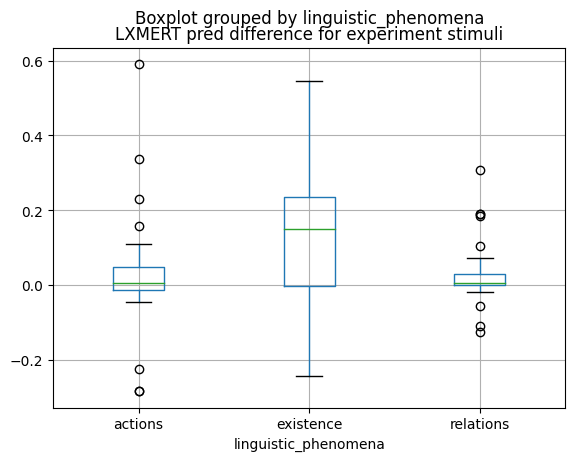

In [34]:
LOAD_STIM_OUTPUT = False
if LOAD_STIM_OUTPUT:

    stimuli_output_df = model_output_dataframe(stimuli_df)

    # export results
    stimuli_output_df.to_pickle(f"xai_output/{model_name}_stimuli_output_scores.pickle")

else:
    stimuli_output_df = pd.read_pickle(f"xai_output/{model_name}_stimuli_output_scores.pickle")

# graph outcome
stimuli_output_df.boxplot(column='model_pred_diff', by='linguistic_phenomena')
plt.title(f"{model_name} pred difference for experiment stimuli")
plt.show()


In [27]:
stimuli_output_df

,img_path,caption,foil,linguistic_phenomena,model_pred_caption,model_pred_foil,model_pred_diff
0,../../VALSE_data/images/v7w/v7w_2318073.jpg,There is at least one light.,There are no lights.,existence,0.211597,0.289828,-0.078232
1,../../VALSE_data/images/v7w/v7w_2323857.jpg,There is fruit.,There is no fruit.,existence,0.834612,0.639575,0.195036


### ONLY OFFLINE: Generate model output for ENTIRE VALSE DATASET for 3 linguistic phenomena

Assuming  only for 3 phenomena

2637it [3:24:06,  4.64s/it]


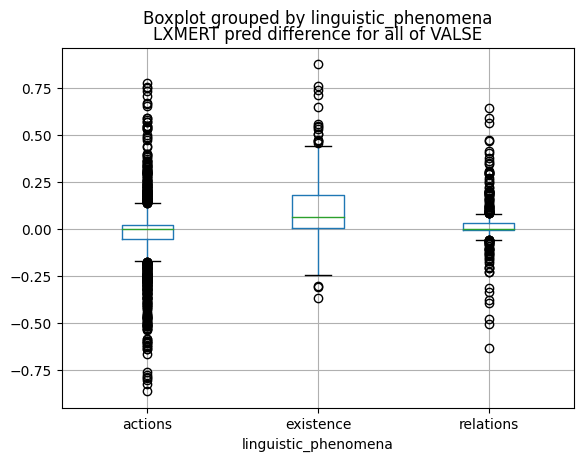

In [46]:
RUN_ON_WHOLE_DATASET = True # can be turned off when we don't need this

if RUN_ON_WHOLE_DATASET and MACHINE == "offline":

    valse_output_df = model_output_dataframe(all_valse_df)

    # export results
    valse_output_df.to_pickle(f"xai_output/{model_name}_all_of_valse_output_scores.pickle")

    # graph outcome
    
try:
    valse_output_df = pd.read_pickle(f"xai_output/{model_name}_all_of_valse_output_scores.pickle")
    valse_output_df
    valse_output_df.boxplot(column='model_pred_diff', by='linguistic_phenomena')
    plt.title(f"{model_name} pred difference for all of VALSE")
    plt.show()
except:
    pass

## Get SHAP functions

### Test masking

In [ ]:
# image = Image.open("../../VALSE_data/images/coco2017/000000122672.jpg")
# image = np.array(image.resize((224,224)))

# blurred_image = blur_image(image)

# test_mask_array = np.array([
#     [1, 0, 0, 1],
#     [0, 1, 1, 0],
#     [1, 0, 0, 0],
#     [0, 0, 1, 0]
# ])

# masked_img = vector_to_masked_images([test_mask_array], image, blurred_image, N_ROWS=4)[0]
# plt.imshow(masked_img)

### SHAP function

# Generate SHAP maps

### Generate SHAP maps

In [50]:
import shap_functions
importlib.reload(shap_functions)

<module 'shap_functions' from '/Users/eduardsaakashvili/Desktop/UU/Thesis/code/es-thesis-repo/data/xai_maps/shap_functions.py'>

Processing rows 3 to 4 out of 99
Processing stimulus 4 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [11:05, 665.71s/it]              


Calculated SHAP values on v7w_2349587.jpg by evaluating a total of 172 image variants.
Processing rows 4 to 5 out of 99
Processing stimulus 5 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [12:41, 761.67s/it]              


Calculated SHAP values on v7w_2352298.jpg by evaluating a total of 172 image variants.
Processing rows 5 to 6 out of 99
Processing stimulus 6 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [10:46, 646.18s/it]              


Calculated SHAP values on v7w_2360434.jpg by evaluating a total of 172 image variants.
Processing rows 6 to 7 out of 99
Processing stimulus 7 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [09:46, 586.91s/it]              


Calculated SHAP values on v7w_2362476.jpg by evaluating a total of 172 image variants.
Processing rows 7 to 8 out of 99
Processing stimulus 8 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [13:19, 799.49s/it]              


Calculated SHAP values on v7w_2389519.jpg by evaluating a total of 172 image variants.
Processing rows 8 to 9 out of 99
Processing stimulus 9 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [13:08, 788.70s/it]              


Calculated SHAP values on v7w_2393355.jpg by evaluating a total of 172 image variants.
Processing rows 9 to 10 out of 99
Processing stimulus 10 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [13:55, 835.63s/it]              


Calculated SHAP values on v7w_2411942.jpg by evaluating a total of 172 image variants.
Processing rows 10 to 11 out of 99
Processing stimulus 11 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [12:07, 727.74s/it]              


Calculated SHAP values on v7w_2417412.jpg by evaluating a total of 172 image variants.
Processing rows 11 to 12 out of 99
Processing stimulus 12 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [09:19, 559.92s/it]              


Calculated SHAP values on speaking_84.jpg by evaluating a total of 172 image variants.
Processing rows 12 to 13 out of 99
Processing stimulus 13 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [10:31, 631.82s/it]              


Calculated SHAP values on tripping_125.jpg by evaluating a total of 172 image variants.
Processing rows 13 to 14 out of 99
Processing stimulus 14 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [10:11, 611.65s/it]              


Calculated SHAP values on punching_28.jpg by evaluating a total of 172 image variants.
Processing rows 14 to 15 out of 99
Processing stimulus 15 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [10:34, 634.13s/it]              


Calculated SHAP values on handcuffing_40.jpg by evaluating a total of 172 image variants.
Processing rows 15 to 16 out of 99
Processing stimulus 16 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [10:35, 635.69s/it]              


Calculated SHAP values on caressing_51.jpg by evaluating a total of 172 image variants.
Processing rows 16 to 17 out of 99
Processing stimulus 17 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [09:20, 560.76s/it]              


Calculated SHAP values on urinating_251.jpg by evaluating a total of 172 image variants.
Processing rows 17 to 18 out of 99
Processing stimulus 18 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [10:13, 613.48s/it]              


Calculated SHAP values on foraging_17.jpg by evaluating a total of 172 image variants.
Processing rows 18 to 19 out of 99
Processing stimulus 19 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [10:05, 605.84s/it]              


Calculated SHAP values on communicating_34.jpg by evaluating a total of 172 image variants.
Processing rows 19 to 20 out of 99
Processing stimulus 20 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [11:28, 688.03s/it]              


Calculated SHAP values on complaining_6.jpg by evaluating a total of 172 image variants.
Processing rows 20 to 21 out of 99
Processing stimulus 21 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [09:56, 596.90s/it]              


Calculated SHAP values on counting_103.jpg by evaluating a total of 172 image variants.
Processing rows 21 to 22 out of 99
Processing stimulus 22 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [10:23, 623.43s/it]              


Calculated SHAP values on socializing_108.jpg by evaluating a total of 172 image variants.
Processing rows 22 to 23 out of 99
Processing stimulus 23 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [12:19, 739.43s/it]              
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


Calculated SHAP values on 000000005529.jpg by evaluating a total of 172 image variants.
Processing rows 23 to 24 out of 99
Processing stimulus 24 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [12:38, 758.19s/it]              
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


Calculated SHAP values on 000000478393.jpg by evaluating a total of 172 image variants.
Processing rows 24 to 25 out of 99
Processing stimulus 25 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [12:23, 743.32s/it]              


Calculated SHAP values on 000000033368.jpg by evaluating a total of 172 image variants.
Processing rows 25 to 26 out of 99
Processing stimulus 26 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [10:39, 639.96s/it]              


Calculated SHAP values on 000000089880.jpg by evaluating a total of 172 image variants.
Processing rows 26 to 27 out of 99
Processing stimulus 27 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [10:48, 648.01s/it]              


Calculated SHAP values on 000000057027.jpg by evaluating a total of 172 image variants.
Processing rows 27 to 28 out of 99
Processing stimulus 28 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [13:44, 824.41s/it]              


Calculated SHAP values on 000000493019.jpg by evaluating a total of 172 image variants.
Processing rows 28 to 29 out of 99
Processing stimulus 29 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [10:28, 628.98s/it]              


Calculated SHAP values on 000000488385.jpg by evaluating a total of 172 image variants.
Processing rows 29 to 30 out of 99
Processing stimulus 30 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [12:28, 748.84s/it]              


Calculated SHAP values on 000000389684.jpg by evaluating a total of 172 image variants.
Processing rows 30 to 31 out of 99
Processing stimulus 31 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [13:57, 837.70s/it]              


Calculated SHAP values on 000000121506.jpg by evaluating a total of 172 image variants.
Processing rows 31 to 32 out of 99
Processing stimulus 32 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [14:51, 891.72s/it]              


Calculated SHAP values on 000000378673.jpg by evaluating a total of 172 image variants.
Processing rows 32 to 33 out of 99
Processing stimulus 33 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [09:48, 588.11s/it]              


Calculated SHAP values on 000000411953.jpg by evaluating a total of 172 image variants.
Processing rows 33 to 34 out of 99
Processing stimulus 34 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [11:34, 694.37s/it]              


Calculated SHAP values on v7w_2331050.jpg by evaluating a total of 172 image variants.
Processing rows 34 to 35 out of 99
Processing stimulus 35 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [14:15, 855.62s/it]              


Calculated SHAP values on v7w_2335370.jpg by evaluating a total of 172 image variants.
Processing rows 35 to 36 out of 99
Processing stimulus 36 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [09:22, 562.27s/it]              


Calculated SHAP values on v7w_2342550.jpg by evaluating a total of 172 image variants.
Processing rows 36 to 37 out of 99
Processing stimulus 37 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [13:03, 783.93s/it]              


Calculated SHAP values on v7w_2345325.jpg by evaluating a total of 172 image variants.
Processing rows 37 to 38 out of 99
Processing stimulus 38 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [11:23, 683.37s/it]              


Calculated SHAP values on v7w_2359944.jpg by evaluating a total of 172 image variants.
Processing rows 38 to 39 out of 99
Processing stimulus 39 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [13:36, 816.72s/it]              


Calculated SHAP values on v7w_2363617.jpg by evaluating a total of 172 image variants.
Processing rows 39 to 40 out of 99
Processing stimulus 40 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [10:50, 650.19s/it]              


Calculated SHAP values on v7w_2370812.jpg by evaluating a total of 172 image variants.
Processing rows 40 to 41 out of 99
Processing stimulus 41 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [11:47, 707.93s/it]              


Calculated SHAP values on v7w_2394557.jpg by evaluating a total of 172 image variants.
Processing rows 41 to 42 out of 99
Processing stimulus 42 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [12:14, 734.35s/it]              


Calculated SHAP values on v7w_2402139.jpg by evaluating a total of 172 image variants.
Processing rows 42 to 43 out of 99
Processing stimulus 43 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [09:09, 549.39s/it]              


Calculated SHAP values on v7w_2407816.jpg by evaluating a total of 172 image variants.
Processing rows 43 to 44 out of 99
Processing stimulus 44 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [13:42, 822.87s/it]              


Calculated SHAP values on v7w_2411632.jpg by evaluating a total of 172 image variants.
Processing rows 44 to 45 out of 99
Processing stimulus 45 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [09:34, 574.25s/it]              


Calculated SHAP values on shushing_24.jpg by evaluating a total of 172 image variants.
Processing rows 45 to 46 out of 99
Processing stimulus 46 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [12:12, 732.53s/it]              


Calculated SHAP values on bandaging_136.jpg by evaluating a total of 172 image variants.
Processing rows 46 to 47 out of 99
Processing stimulus 47 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [11:45, 705.18s/it]              


Calculated SHAP values on chasing_345.jpg by evaluating a total of 172 image variants.
Processing rows 47 to 48 out of 99
Processing stimulus 48 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [09:13, 553.17s/it]              


Calculated SHAP values on buttoning_129.jpg by evaluating a total of 172 image variants.
Processing rows 48 to 49 out of 99
Processing stimulus 49 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [11:13, 673.35s/it]              


Calculated SHAP values on admiring_372.jpg by evaluating a total of 172 image variants.
Processing rows 49 to 50 out of 99
Processing stimulus 50 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [11:48, 708.85s/it]              


Calculated SHAP values on driving_253.jpg by evaluating a total of 172 image variants.
Processing rows 50 to 51 out of 99
Processing stimulus 51 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [13:16, 796.72s/it]              


Calculated SHAP values on tackling_118.jpg by evaluating a total of 172 image variants.
Processing rows 51 to 52 out of 99
Processing stimulus 52 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [09:59, 599.76s/it]              


Calculated SHAP values on licking_291.jpg by evaluating a total of 172 image variants.
Processing rows 52 to 53 out of 99
Processing stimulus 53 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [10:08, 608.21s/it]              


Calculated SHAP values on scolding_30.jpg by evaluating a total of 172 image variants.
Processing rows 53 to 54 out of 99
Processing stimulus 54 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [08:33, 513.59s/it]              


Calculated SHAP values on peeing_115.jpg by evaluating a total of 172 image variants.
Processing rows 54 to 55 out of 99
Processing stimulus 55 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [13:49, 829.32s/it]              


Calculated SHAP values on chasing_258.jpg by evaluating a total of 172 image variants.
Processing rows 55 to 56 out of 99
Processing stimulus 56 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [14:43, 883.67s/it]              


Calculated SHAP values on 000000461751.jpg by evaluating a total of 172 image variants.
Processing rows 56 to 57 out of 99
Processing stimulus 57 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [14:44, 884.36s/it]              


Calculated SHAP values on 000000027620.jpg by evaluating a total of 172 image variants.
Processing rows 57 to 58 out of 99
Processing stimulus 58 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [14:14, 854.99s/it]              


Calculated SHAP values on 000000350405.jpg by evaluating a total of 172 image variants.
Processing rows 58 to 59 out of 99
Processing stimulus 59 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [16:34, 994.44s/it]              


Calculated SHAP values on 000000119641.jpg by evaluating a total of 172 image variants.
Processing rows 59 to 60 out of 99
Processing stimulus 60 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [13:55, 835.19s/it]              


Calculated SHAP values on 000000021903.jpg by evaluating a total of 172 image variants.
Processing rows 60 to 61 out of 99
Processing stimulus 61 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [14:51, 891.41s/it]              


Calculated SHAP values on 000000278848.jpg by evaluating a total of 172 image variants.
Processing rows 61 to 62 out of 99
Processing stimulus 62 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [13:33, 813.16s/it]              


Calculated SHAP values on 000000272364.jpg by evaluating a total of 172 image variants.
Processing rows 62 to 63 out of 99
Processing stimulus 63 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [14:48, 888.66s/it]              


Calculated SHAP values on 000000320554.jpg by evaluating a total of 172 image variants.
Processing rows 63 to 64 out of 99
Processing stimulus 64 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [18:47, 1127.95s/it]             


Calculated SHAP values on 000000260106.jpg by evaluating a total of 172 image variants.
Processing rows 64 to 65 out of 99
Processing stimulus 65 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [12:09, 729.72s/it]              


Calculated SHAP values on 000000112997.jpg by evaluating a total of 172 image variants.
Processing rows 65 to 66 out of 99
Processing stimulus 66 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [11:41, 701.36s/it]              


Calculated SHAP values on 000000482436.jpg by evaluating a total of 172 image variants.
Processing rows 66 to 67 out of 99
Processing stimulus 67 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [11:00, 660.14s/it]              


Calculated SHAP values on v7w_2316446.jpg by evaluating a total of 172 image variants.
Processing rows 67 to 68 out of 99
Processing stimulus 68 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [11:37, 697.04s/it]              


Calculated SHAP values on v7w_2325309.jpg by evaluating a total of 172 image variants.
Processing rows 68 to 69 out of 99
Processing stimulus 69 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [12:55, 775.37s/it]              


Calculated SHAP values on v7w_2328270.jpg by evaluating a total of 172 image variants.
Processing rows 69 to 70 out of 99
Processing stimulus 70 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [11:40, 700.83s/it]              


Calculated SHAP values on v7w_2345780.jpg by evaluating a total of 172 image variants.
Processing rows 70 to 71 out of 99
Processing stimulus 71 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [12:26, 746.86s/it]              


Calculated SHAP values on v7w_2359039.jpg by evaluating a total of 172 image variants.
Processing rows 71 to 72 out of 99
Processing stimulus 72 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [14:14, 854.87s/it]              


Calculated SHAP values on v7w_2361437.jpg by evaluating a total of 172 image variants.
Processing rows 72 to 73 out of 99
Processing stimulus 73 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [14:26, 866.85s/it]              


Calculated SHAP values on v7w_2363335.jpg by evaluating a total of 172 image variants.
Processing rows 73 to 74 out of 99
Processing stimulus 74 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [11:12, 672.89s/it]              


Calculated SHAP values on v7w_2367084.jpg by evaluating a total of 172 image variants.
Processing rows 74 to 75 out of 99
Processing stimulus 75 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [15:22, 922.89s/it]              


Calculated SHAP values on v7w_2373121.jpg by evaluating a total of 172 image variants.
Processing rows 75 to 76 out of 99
Processing stimulus 76 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [11:49, 709.95s/it]              


Calculated SHAP values on v7w_2390850.jpg by evaluating a total of 172 image variants.
Processing rows 76 to 77 out of 99
Processing stimulus 77 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [13:14, 794.05s/it]              


Calculated SHAP values on v7w_2416322.jpg by evaluating a total of 172 image variants.
Processing rows 77 to 78 out of 99
Processing stimulus 78 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [11:20, 680.41s/it]              


Calculated SHAP values on shopping_215.jpg by evaluating a total of 172 image variants.
Processing rows 78 to 79 out of 99
Processing stimulus 79 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [12:17, 737.49s/it]              


Calculated SHAP values on frisking_20.jpg by evaluating a total of 172 image variants.
Processing rows 79 to 80 out of 99
Processing stimulus 80 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [11:40, 700.11s/it]              


Calculated SHAP values on instructing_116.jpg by evaluating a total of 172 image variants.
Processing rows 80 to 81 out of 99
Processing stimulus 81 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [12:13, 733.92s/it]              


Calculated SHAP values on subduing_201.jpg by evaluating a total of 172 image variants.
Processing rows 81 to 82 out of 99
Processing stimulus 82 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [09:05, 545.94s/it]              


Calculated SHAP values on scolding_34.jpg by evaluating a total of 172 image variants.
Processing rows 82 to 83 out of 99
Processing stimulus 83 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [09:13, 553.51s/it]              


Calculated SHAP values on imitating_145.jpg by evaluating a total of 172 image variants.
Processing rows 83 to 84 out of 99
Processing stimulus 84 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [12:03, 723.53s/it]              


Calculated SHAP values on training_228.jpg by evaluating a total of 172 image variants.
Processing rows 84 to 85 out of 99
Processing stimulus 85 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [11:46, 706.13s/it]              


Calculated SHAP values on brewing_85.jpg by evaluating a total of 172 image variants.
Processing rows 85 to 86 out of 99
Processing stimulus 86 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [11:56, 716.13s/it]              


Calculated SHAP values on coaching_90.jpg by evaluating a total of 172 image variants.
Processing rows 86 to 87 out of 99
Processing stimulus 87 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [13:12, 792.11s/it]              


Calculated SHAP values on punting_194.jpg by evaluating a total of 172 image variants.
Processing rows 87 to 88 out of 99
Processing stimulus 88 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [13:37, 817.56s/it]              


Calculated SHAP values on leading_42.jpg by evaluating a total of 172 image variants.
Processing rows 88 to 89 out of 99
Processing stimulus 89 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [15:21, 921.97s/it]              


Calculated SHAP values on 000000001584.jpg by evaluating a total of 172 image variants.
Processing rows 89 to 90 out of 99
Processing stimulus 90 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [17:54, 1074.06s/it]             


Calculated SHAP values on 000000511599.jpg by evaluating a total of 172 image variants.
Processing rows 90 to 91 out of 99
Processing stimulus 91 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [11:10, 670.15s/it]              


Calculated SHAP values on 000000229858.jpg by evaluating a total of 172 image variants.
Processing rows 91 to 92 out of 99
Processing stimulus 92 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [13:47, 827.88s/it]              


Calculated SHAP values on 000000384666.jpg by evaluating a total of 172 image variants.
Processing rows 92 to 93 out of 99
Processing stimulus 93 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [15:10, 910.22s/it]              


Calculated SHAP values on 000000393093.jpg by evaluating a total of 172 image variants.
Processing rows 93 to 94 out of 99
Processing stimulus 94 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [14:56, 896.27s/it]              


Calculated SHAP values on 000000164885.jpg by evaluating a total of 172 image variants.
Processing rows 94 to 95 out of 99
Processing stimulus 95 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [12:13, 733.67s/it]              


Calculated SHAP values on 000000121586.jpg by evaluating a total of 172 image variants.
Processing rows 95 to 96 out of 99
Processing stimulus 96 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [13:43, 823.89s/it]              


Calculated SHAP values on 000000082696.jpg by evaluating a total of 172 image variants.
Processing rows 96 to 97 out of 99
Processing stimulus 97 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [11:56, 716.00s/it]              


Calculated SHAP values on 000000038118.jpg by evaluating a total of 172 image variants.
Processing rows 97 to 98 out of 99
Processing stimulus 98 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [12:01, 721.45s/it]              


Calculated SHAP values on 000000273711.jpg by evaluating a total of 172 image variants.
Processing rows 98 to 99 out of 99
Processing stimulus 99 out of 99
Image shape: (224, 224, 3)
SHAP matrix shape: (1, 4, 4)


  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [14:35, 875.98s/it]              


Calculated SHAP values on 000000376307.jpg by evaluating a total of 172 image variants.


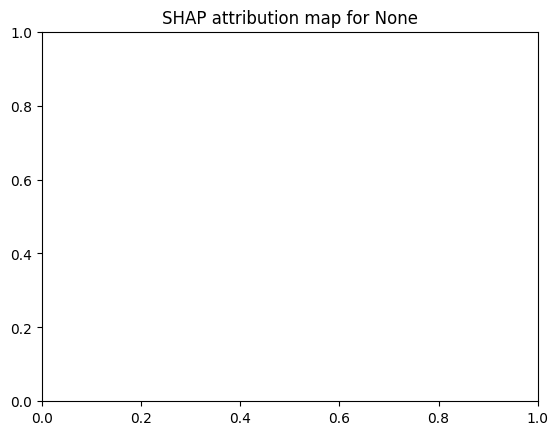

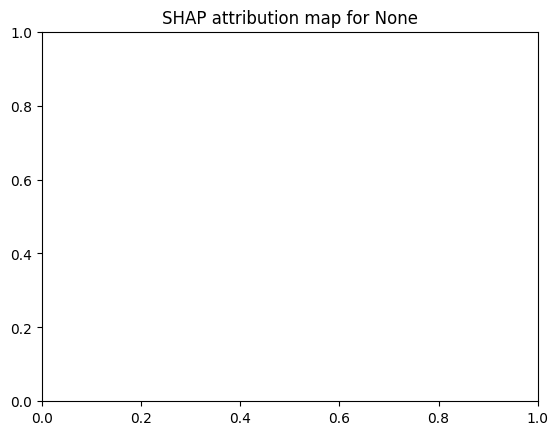

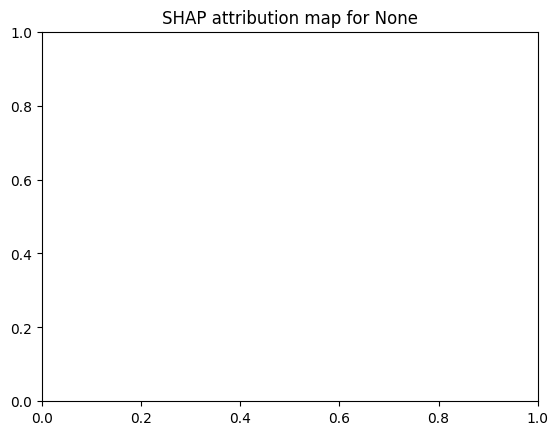

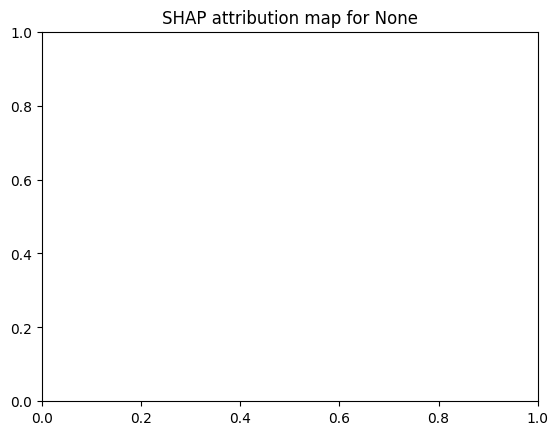

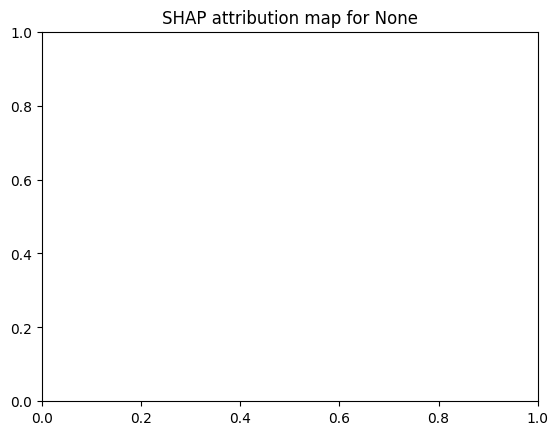

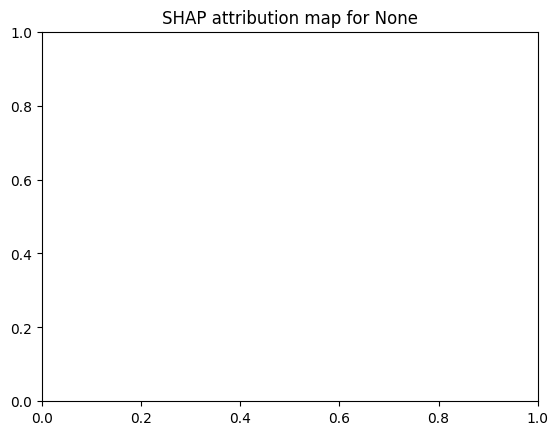

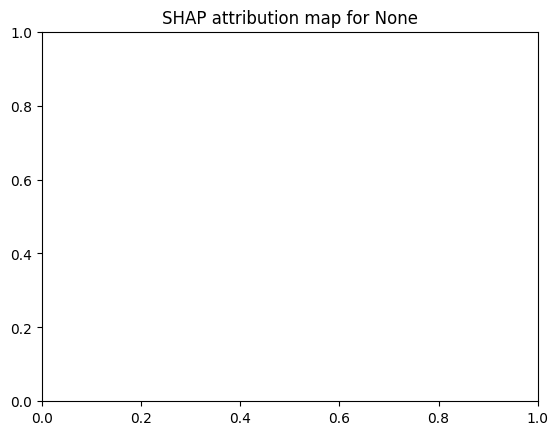

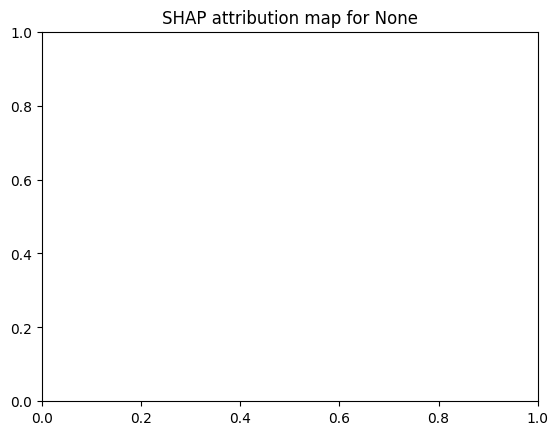

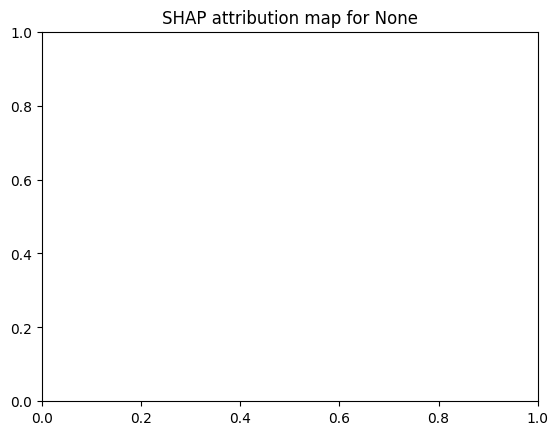

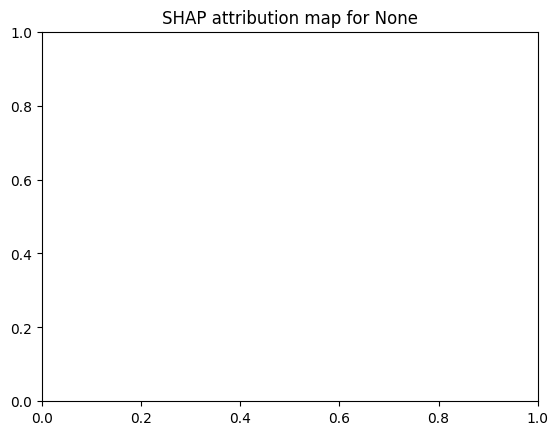

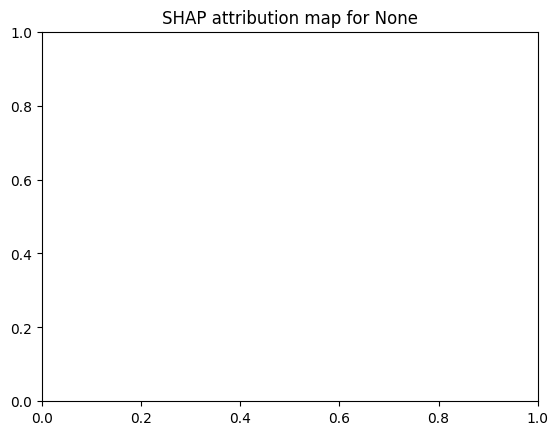

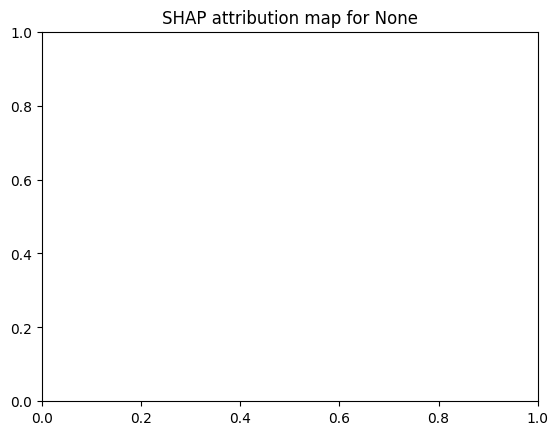

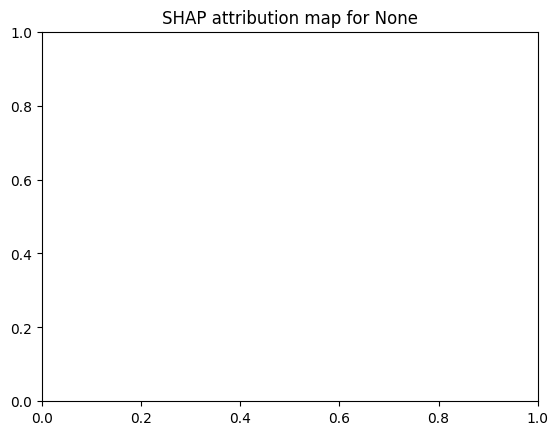

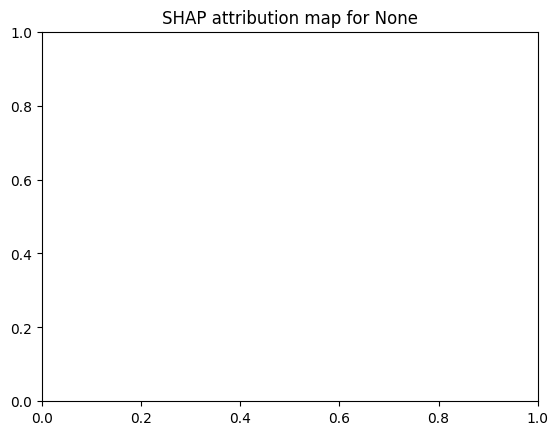

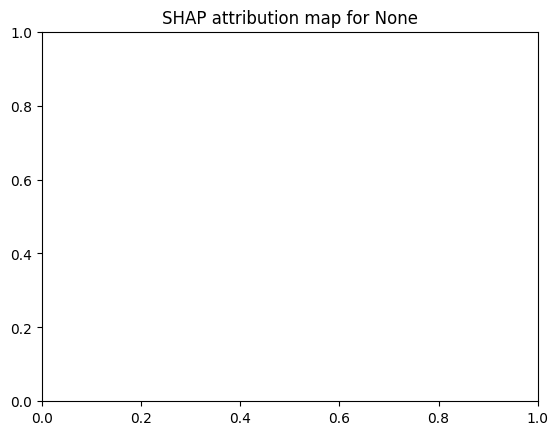

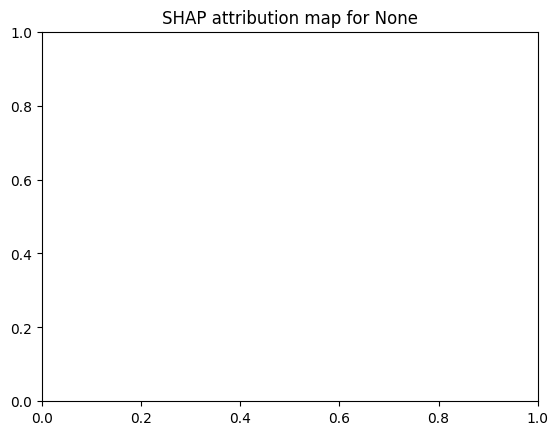

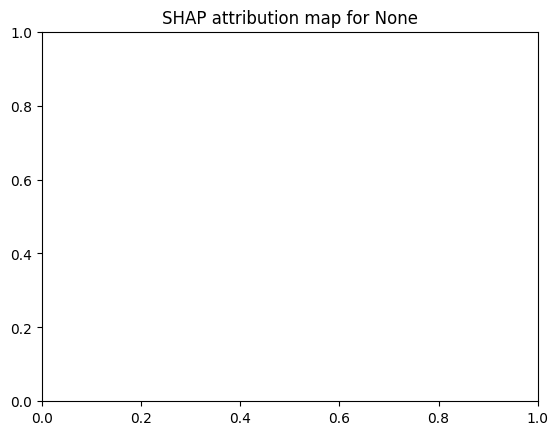

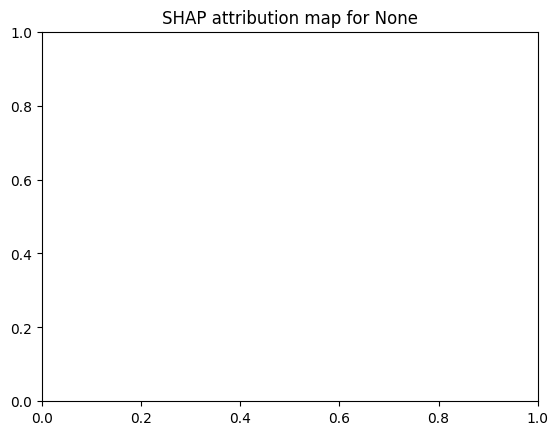

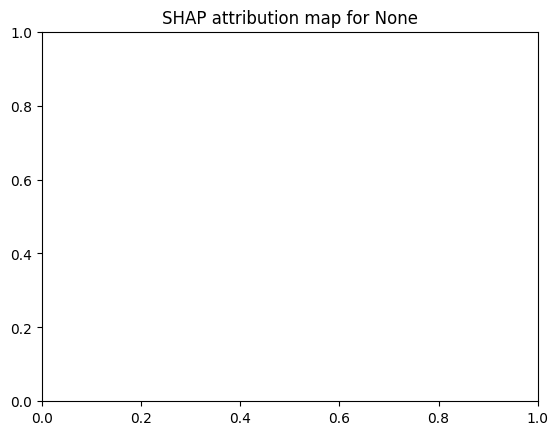

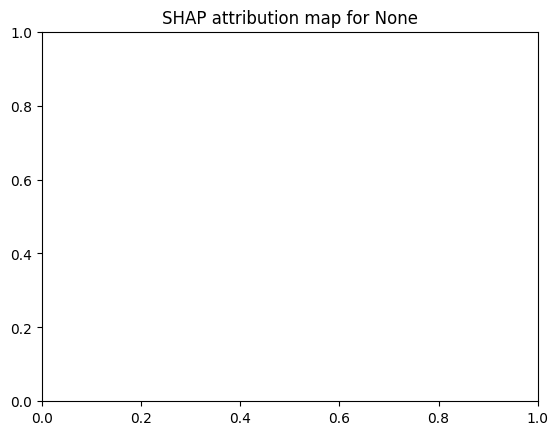

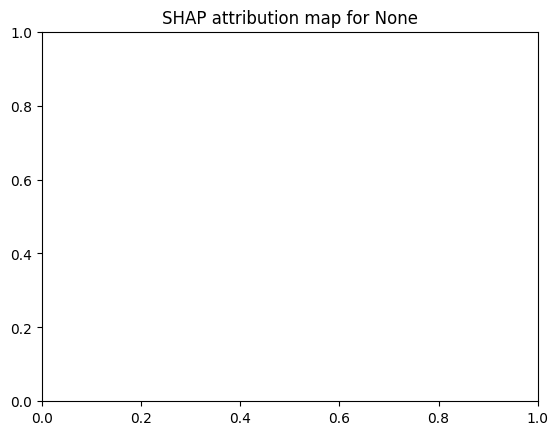

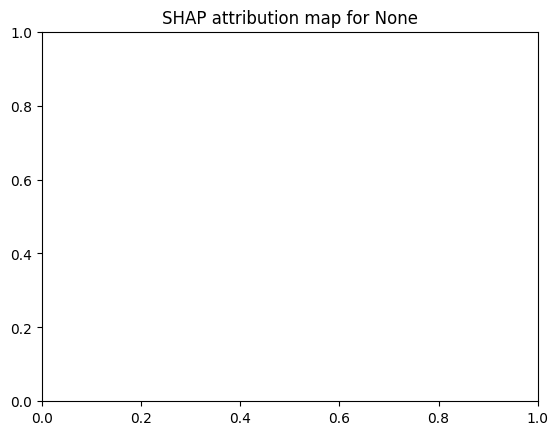

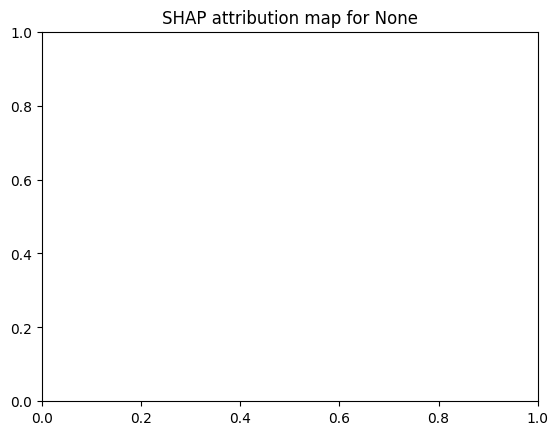

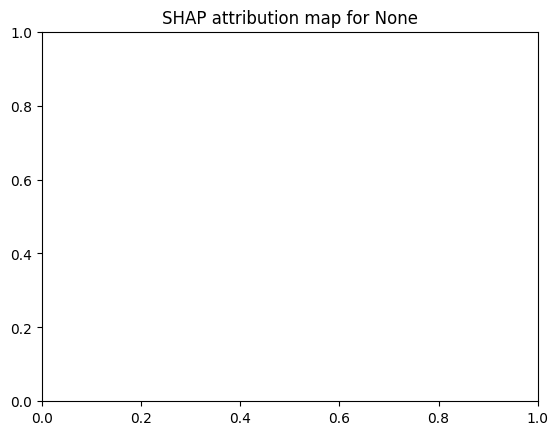

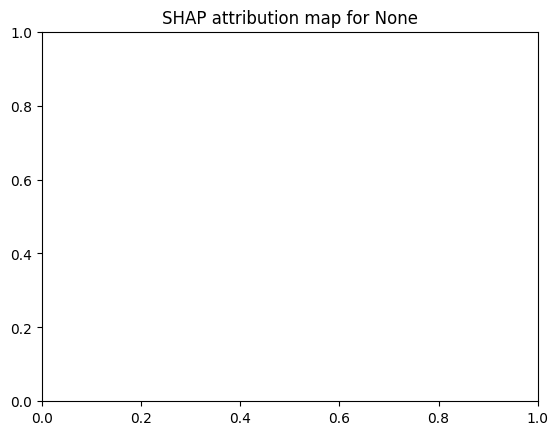

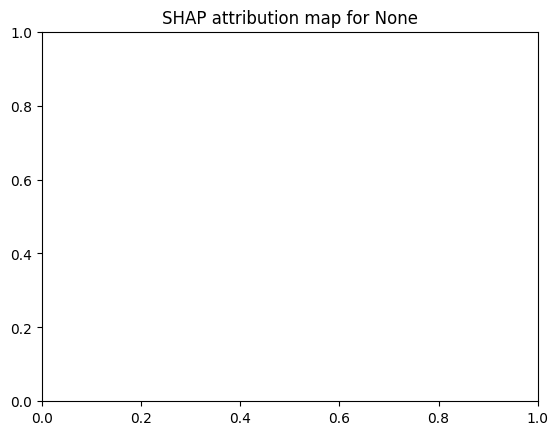

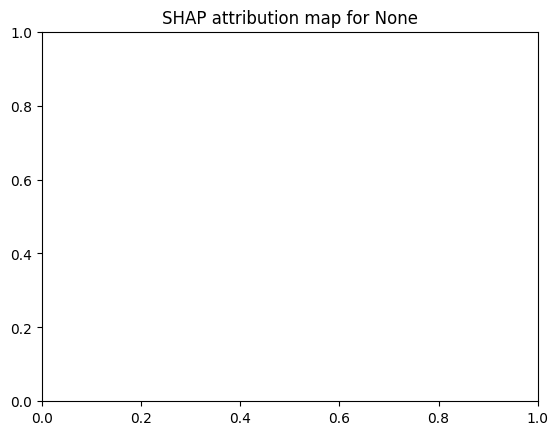

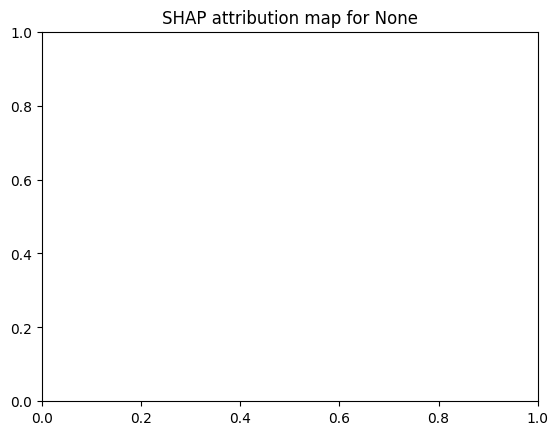

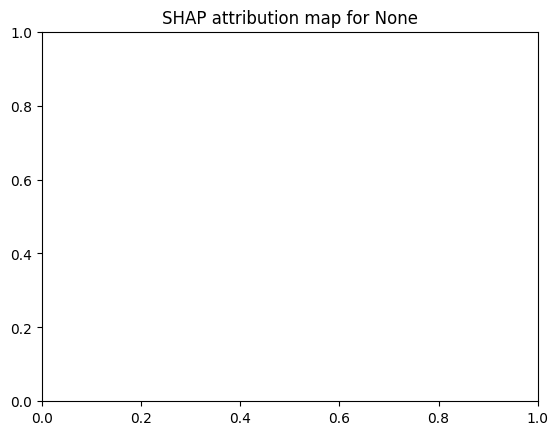

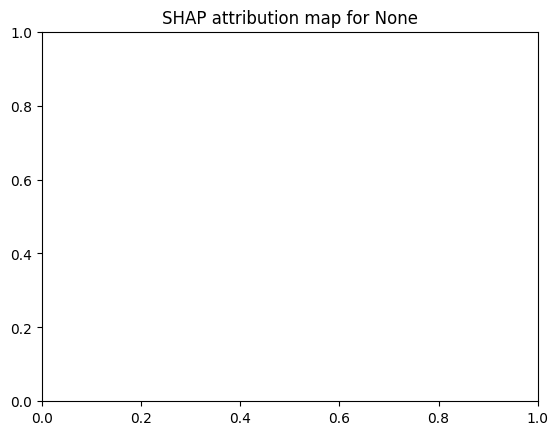

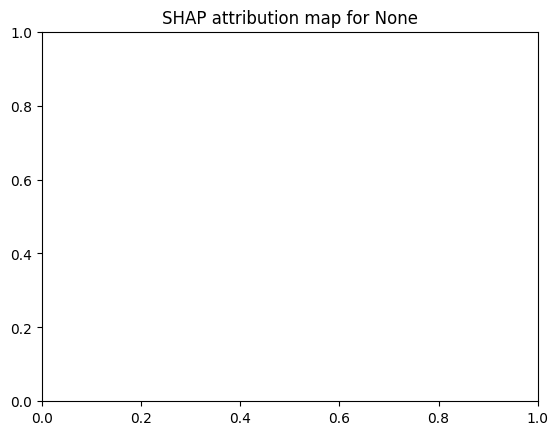

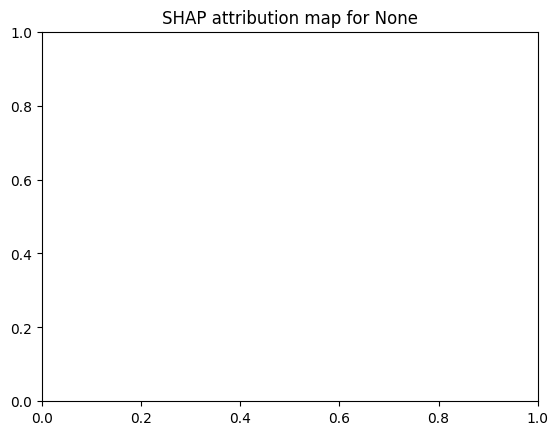

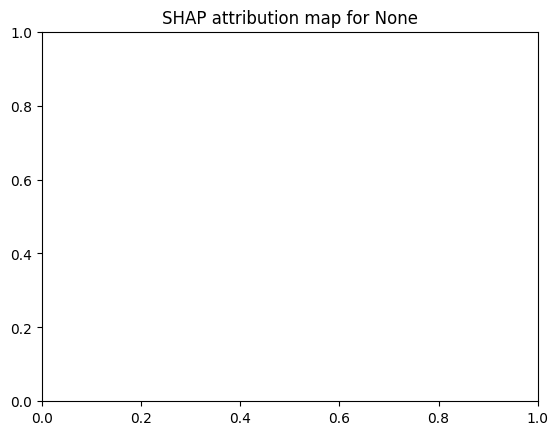

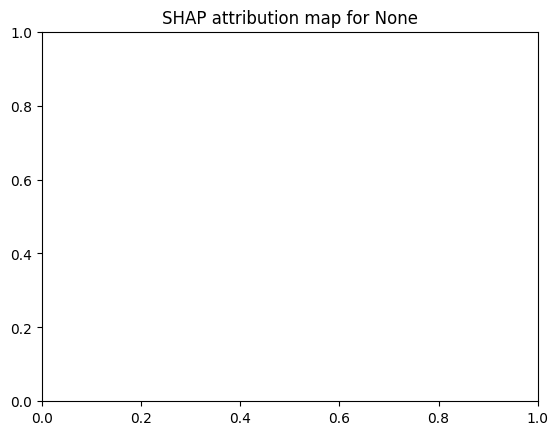

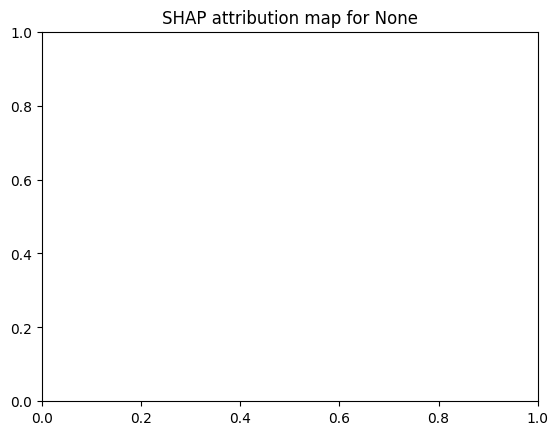

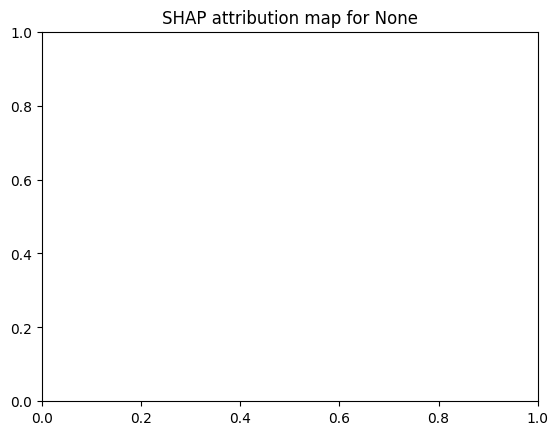

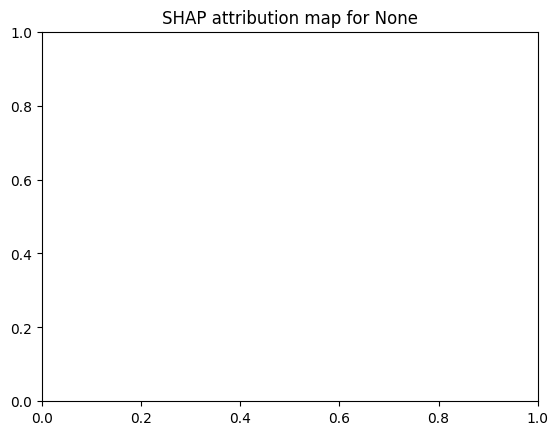

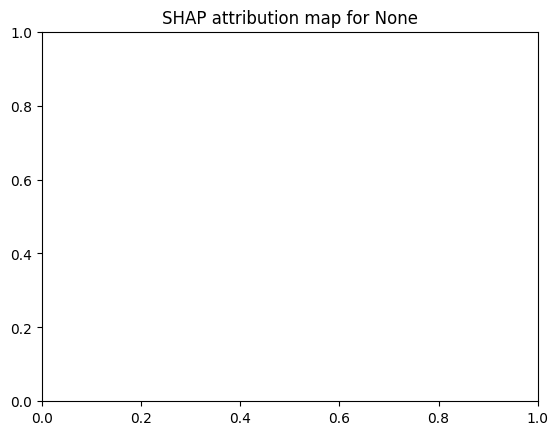

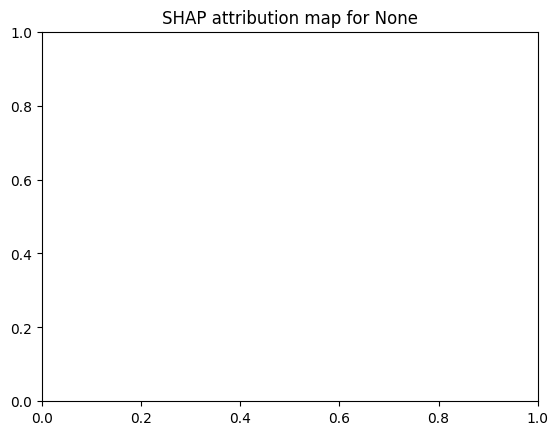

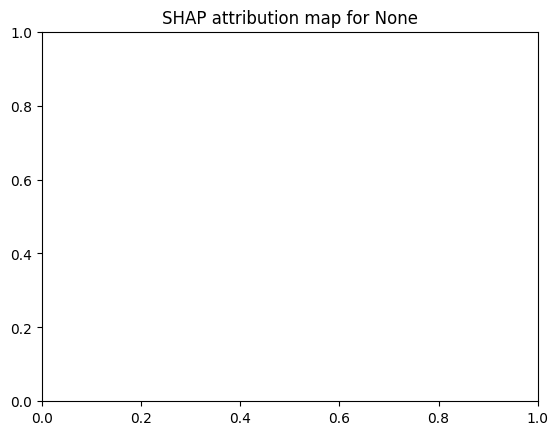

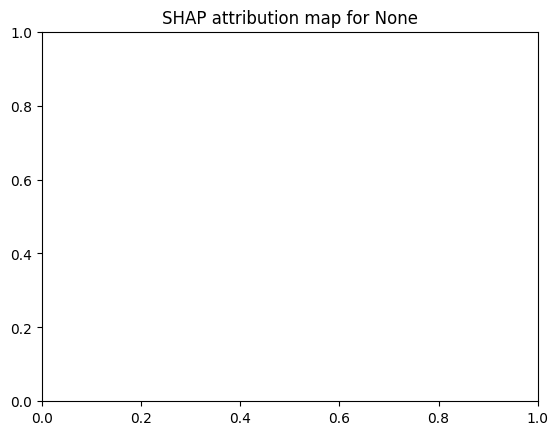

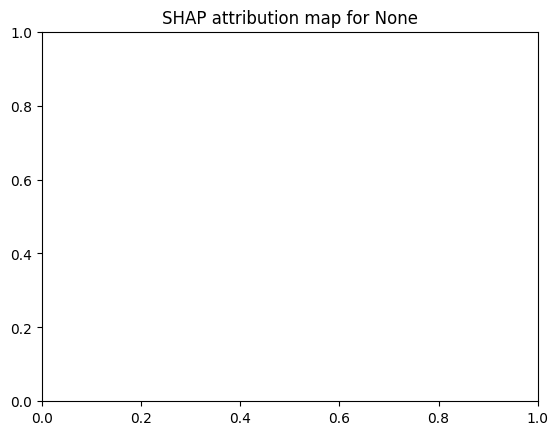

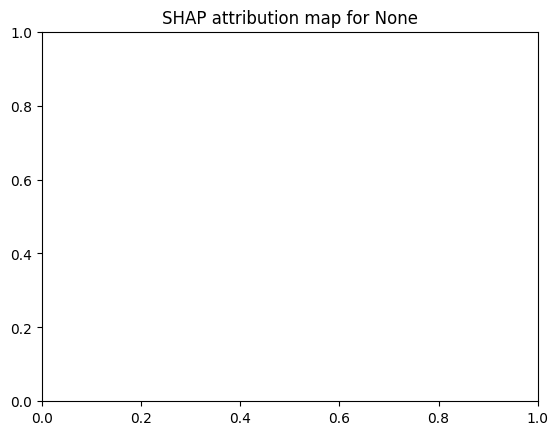

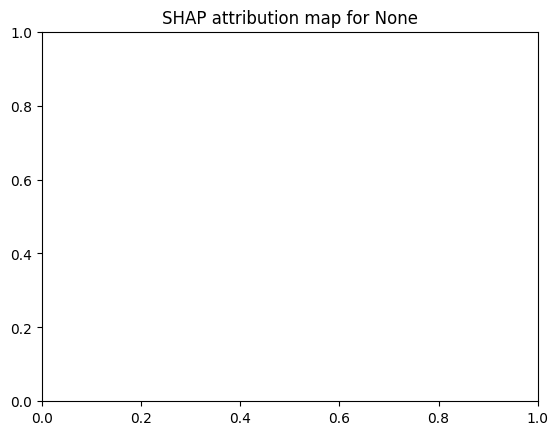

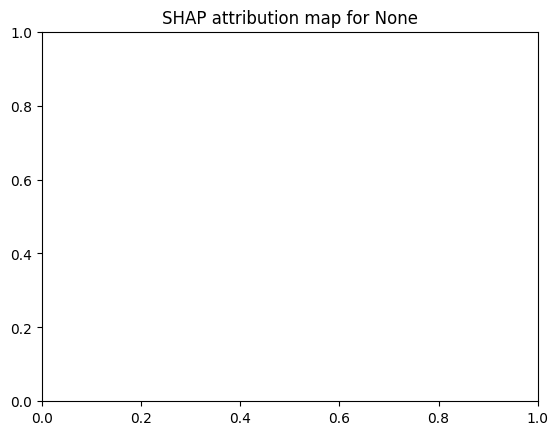

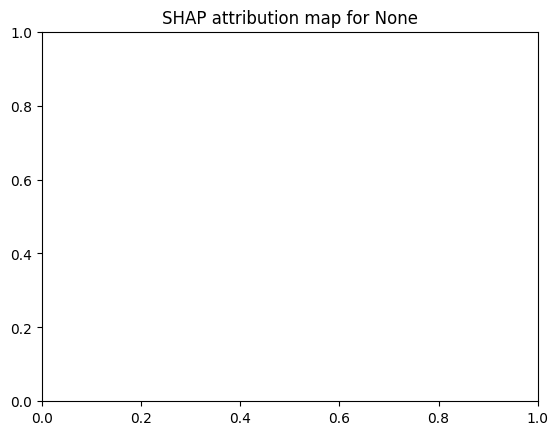

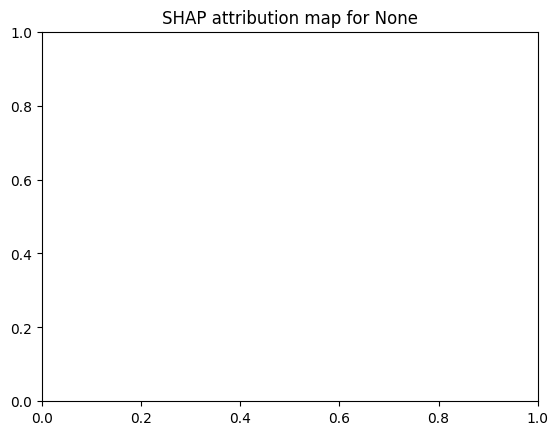

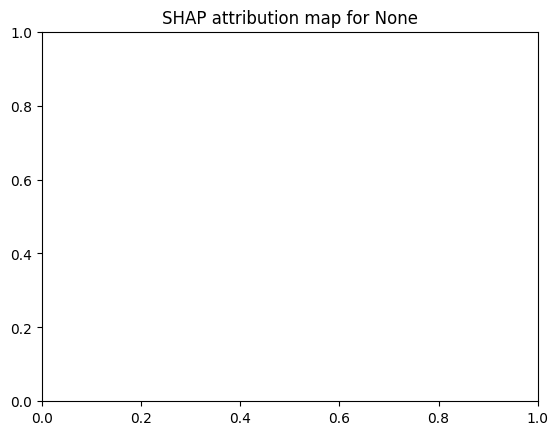

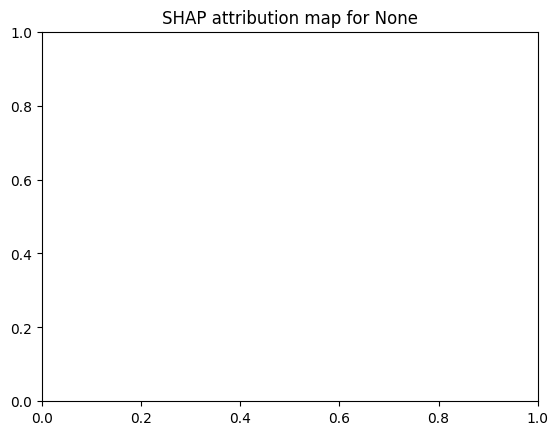

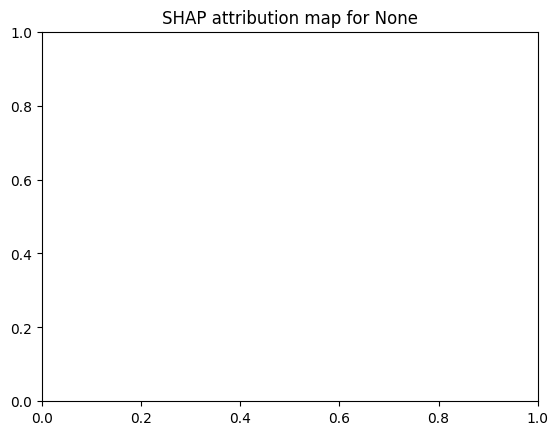

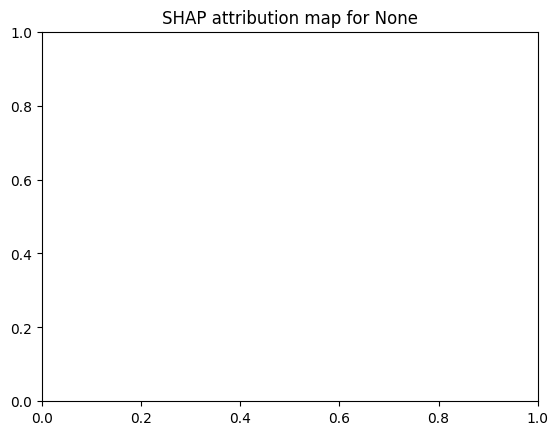

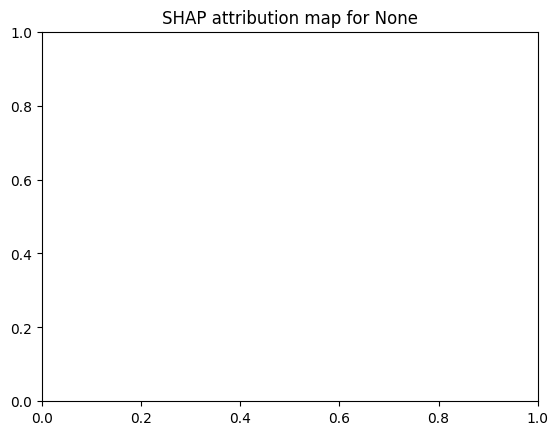

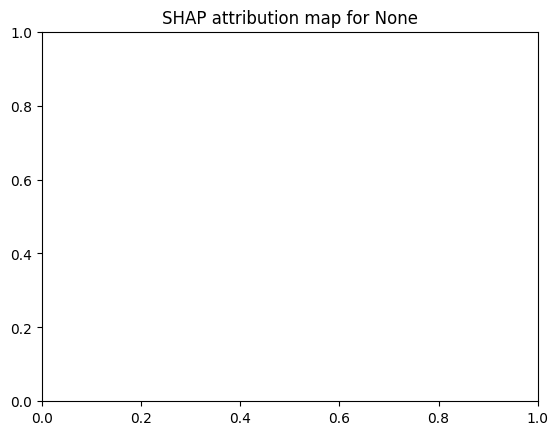

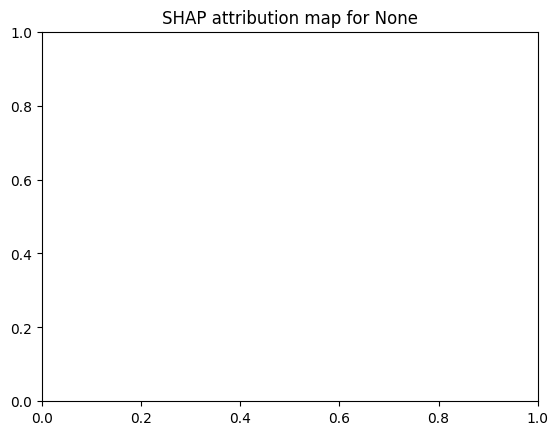

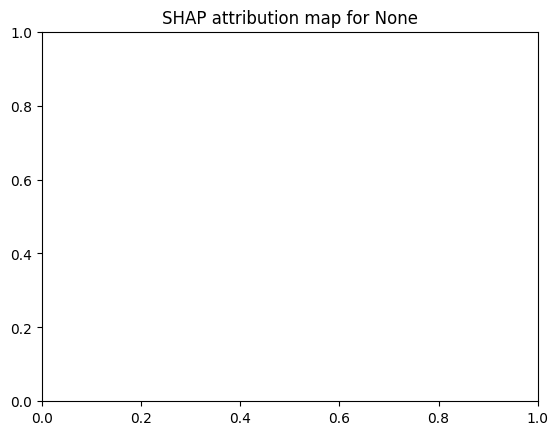

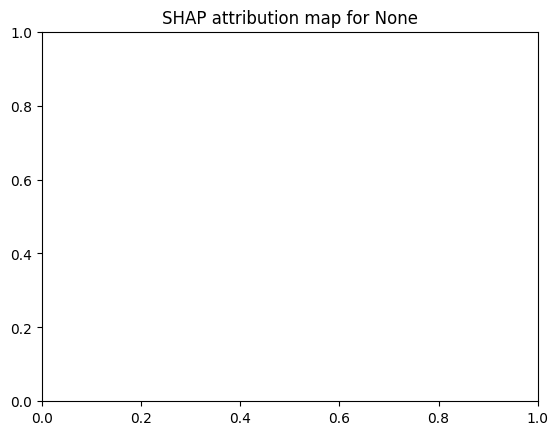

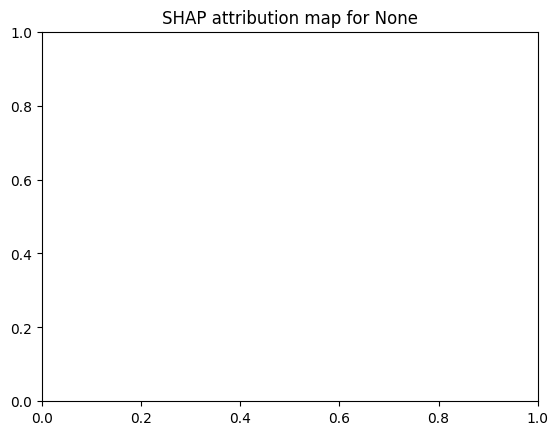

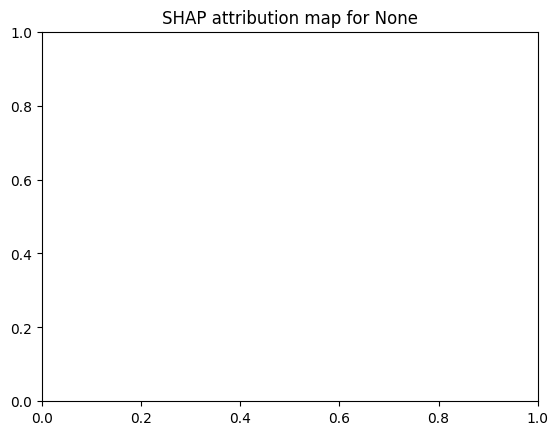

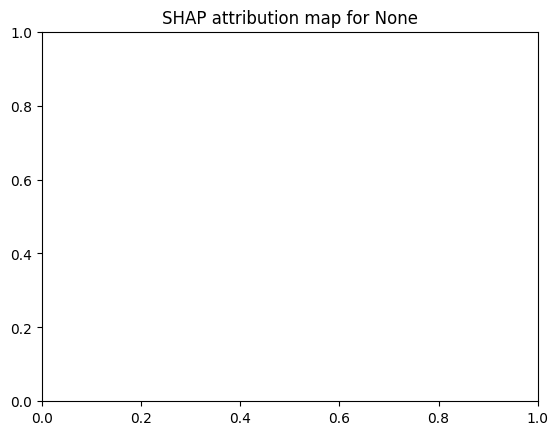

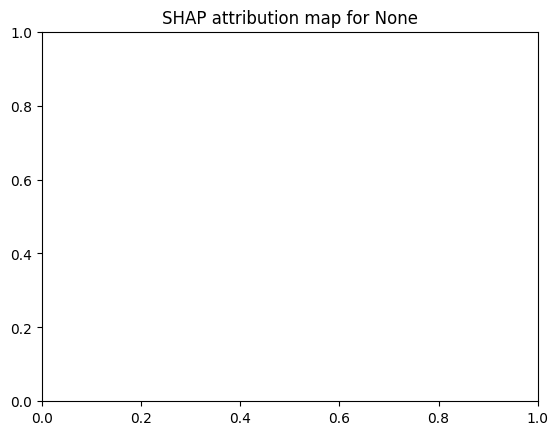

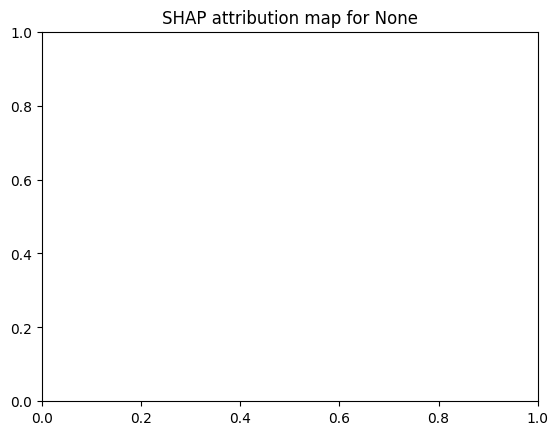

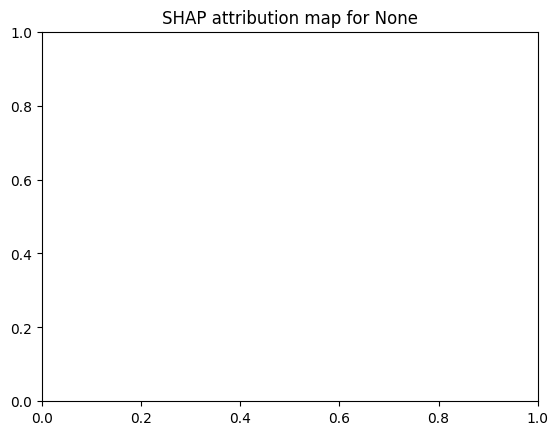

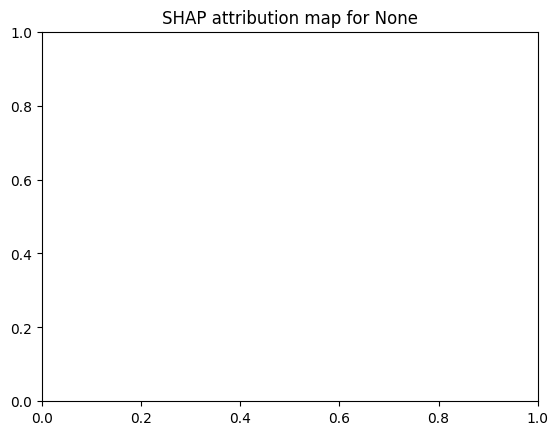

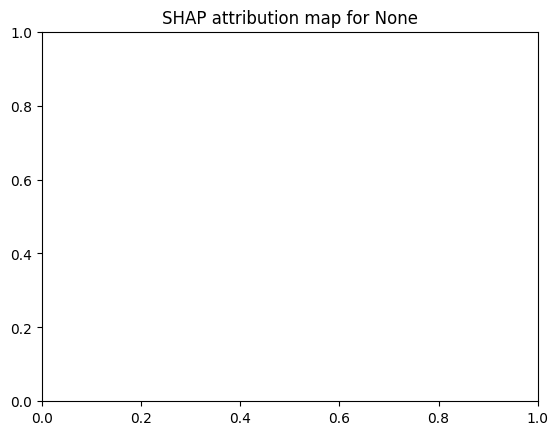

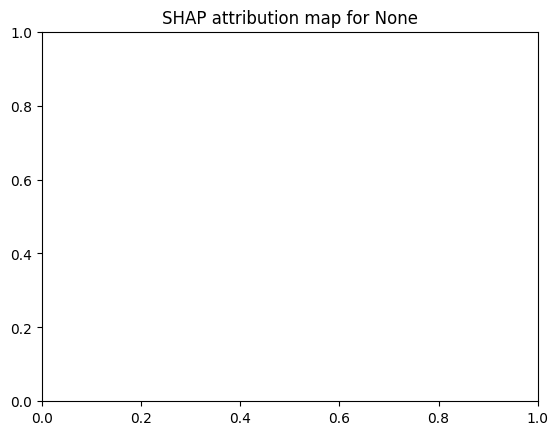

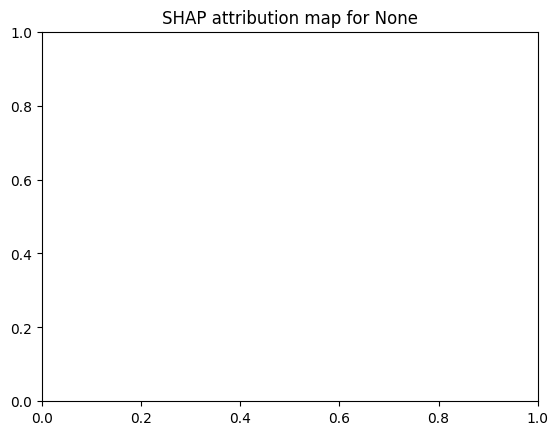

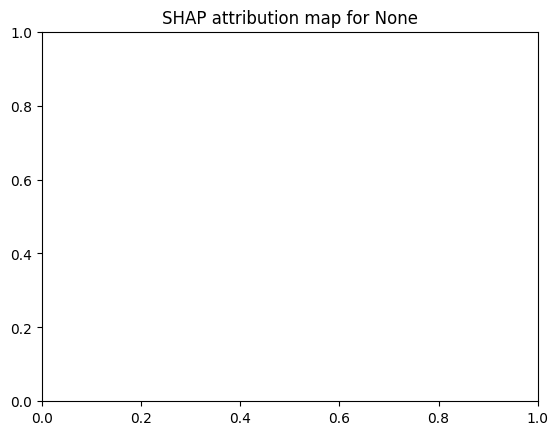

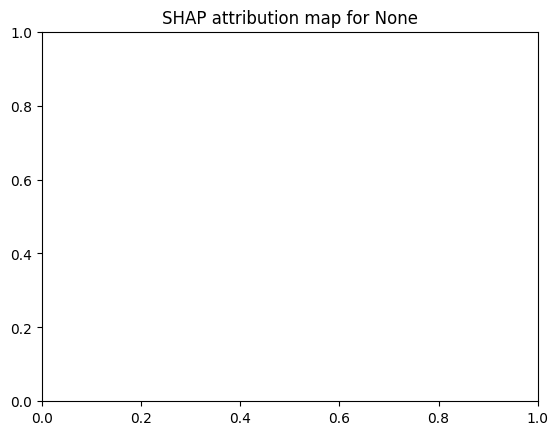

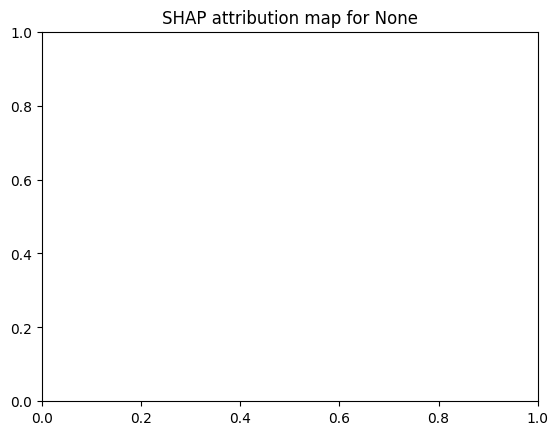

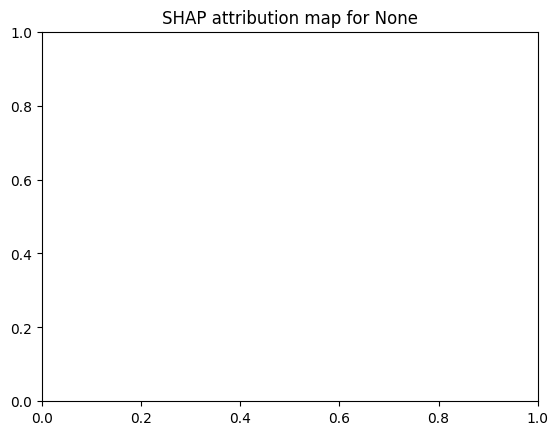

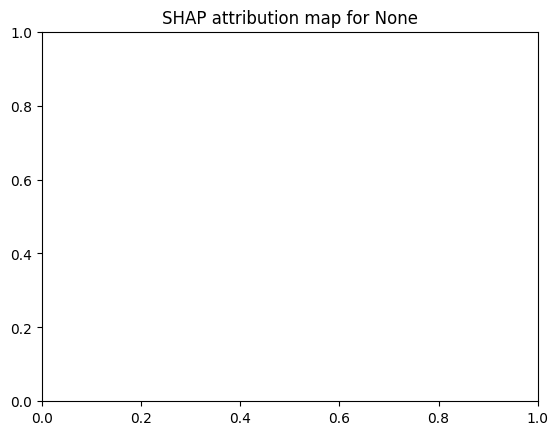

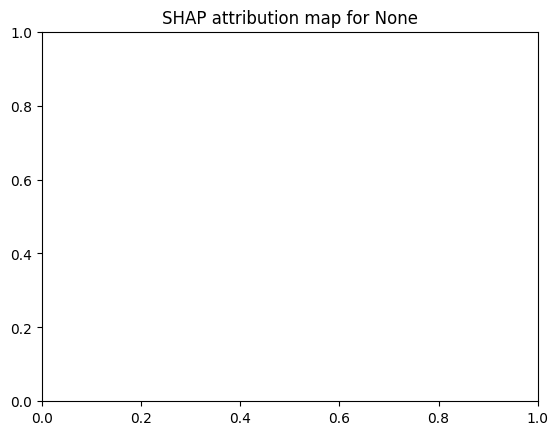

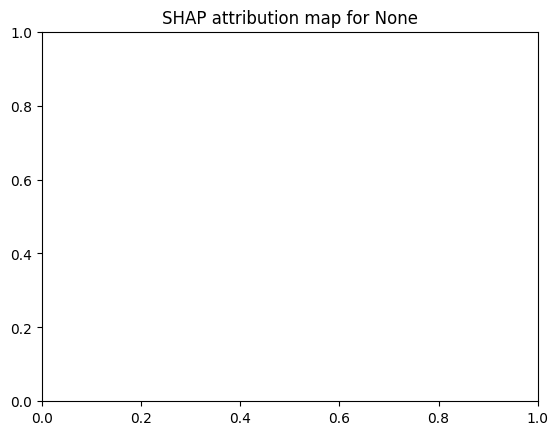

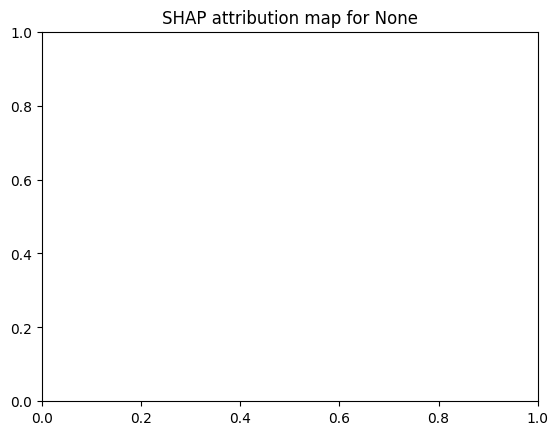

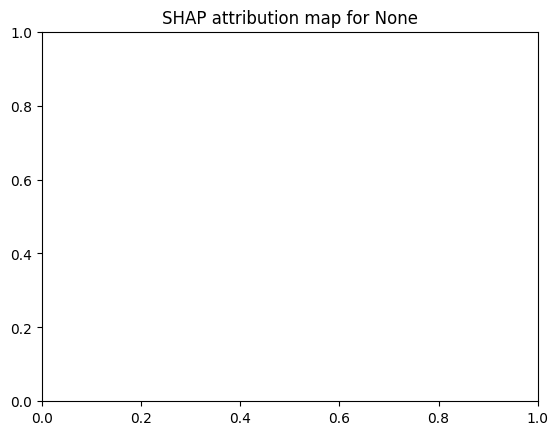

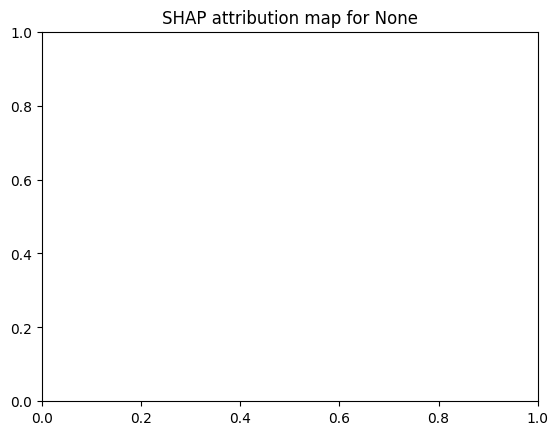

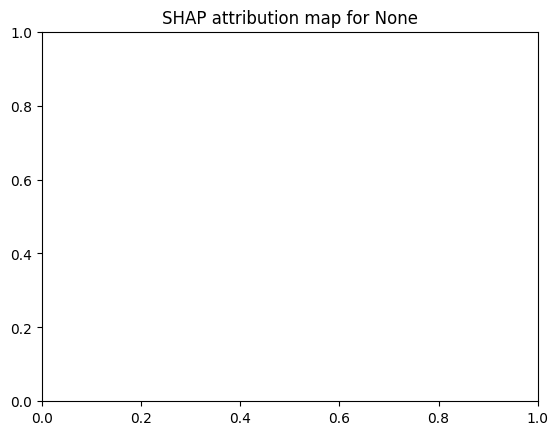

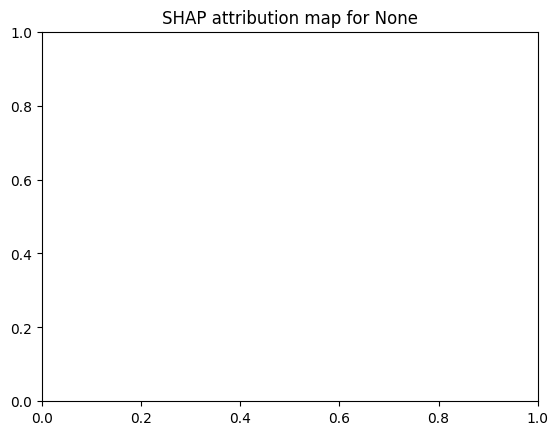

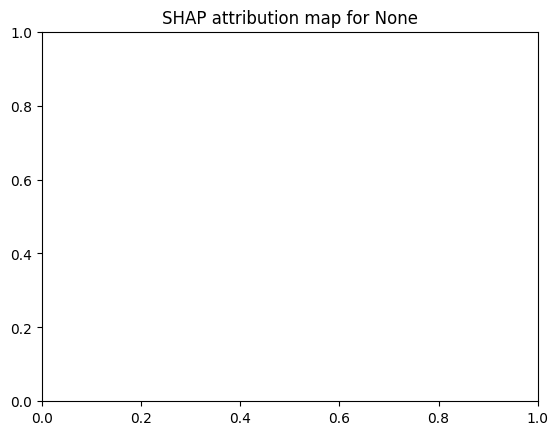

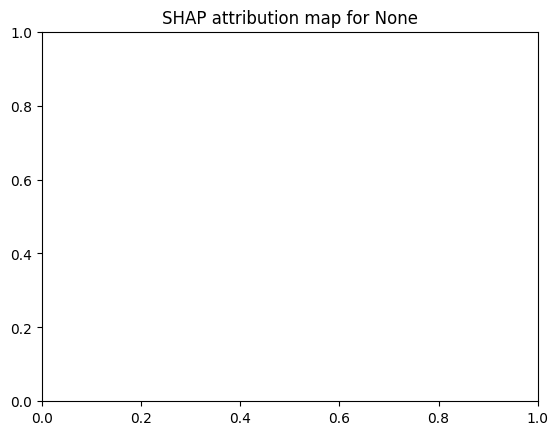

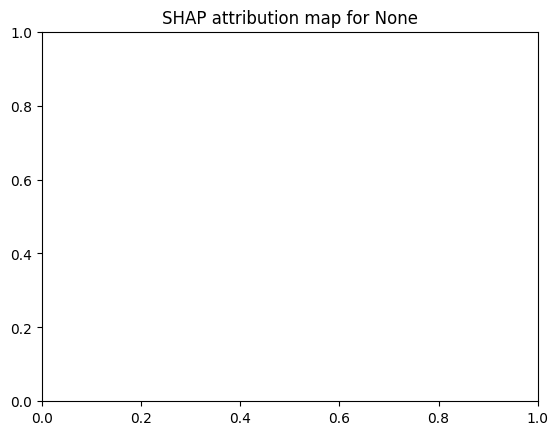

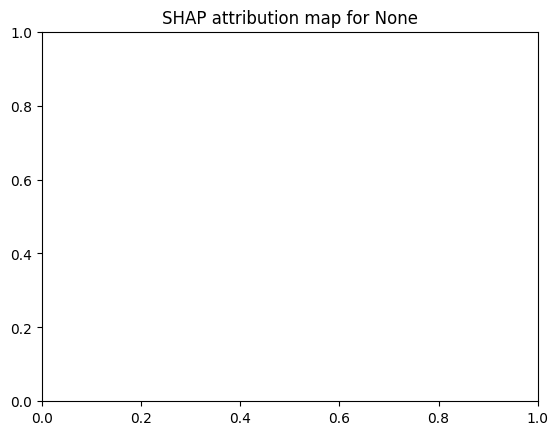

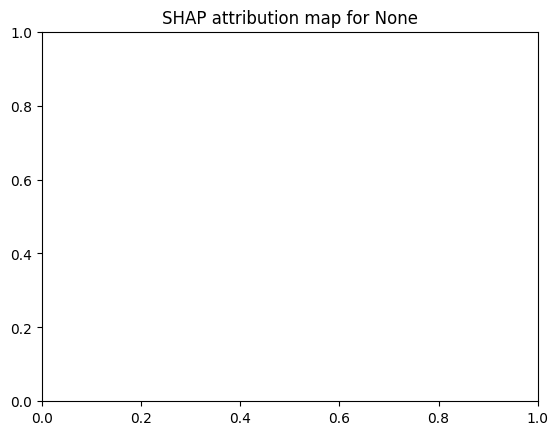

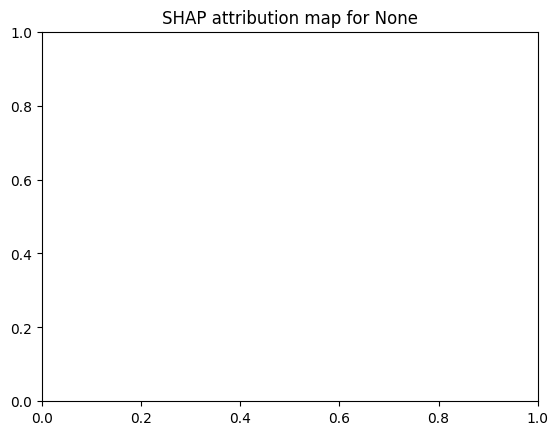

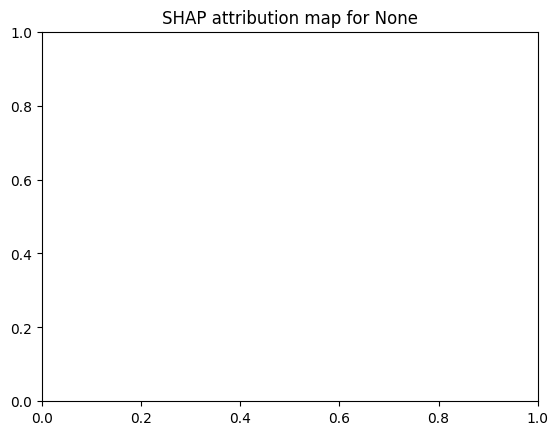

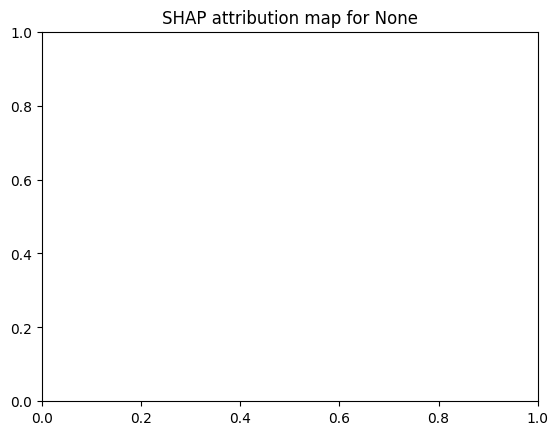

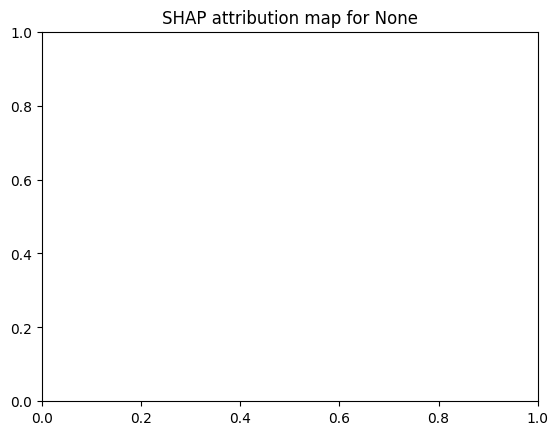

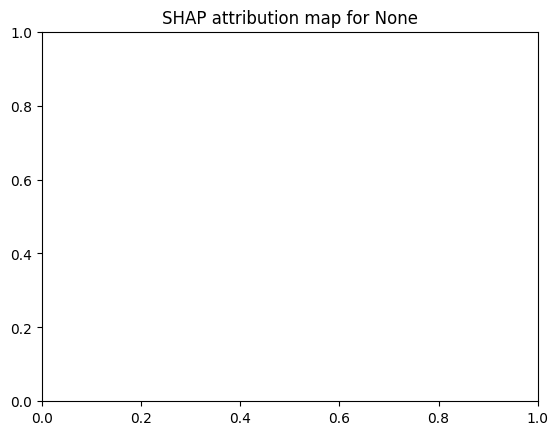

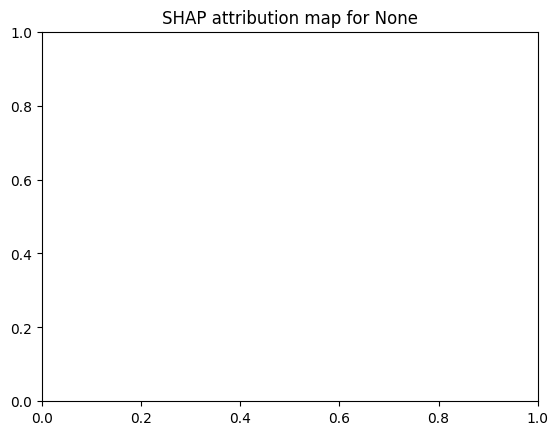

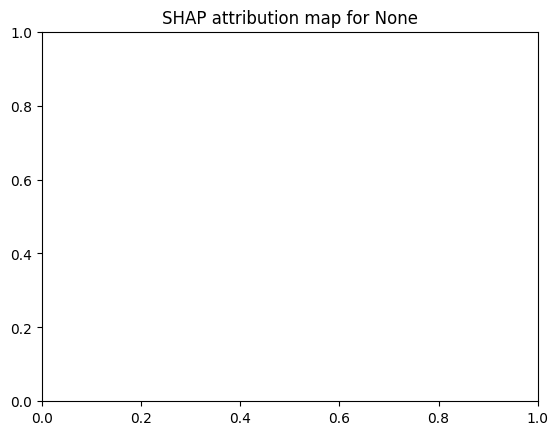

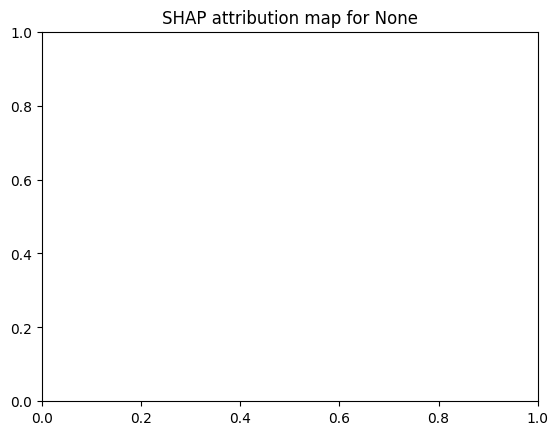

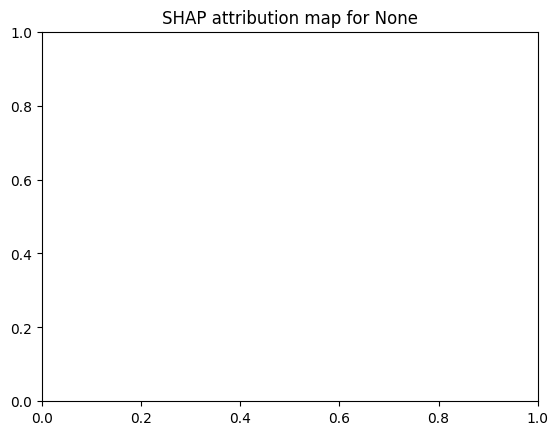

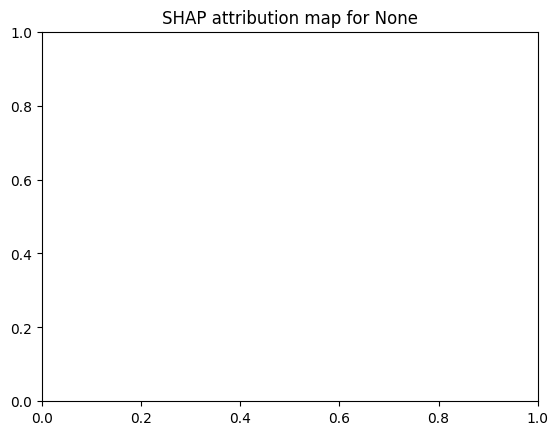

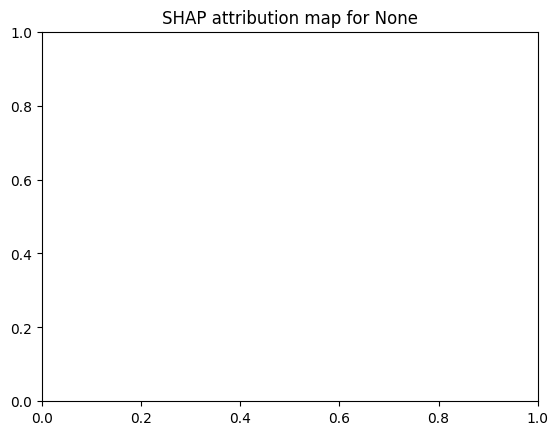

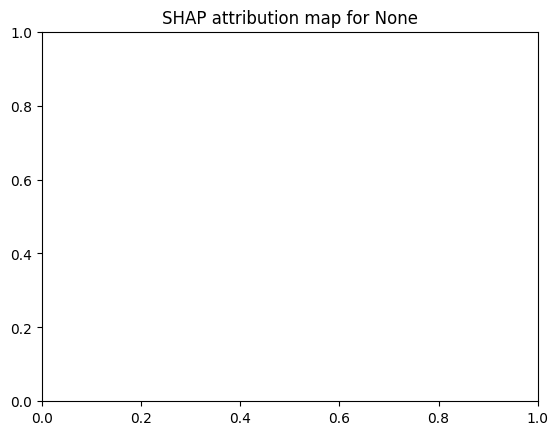

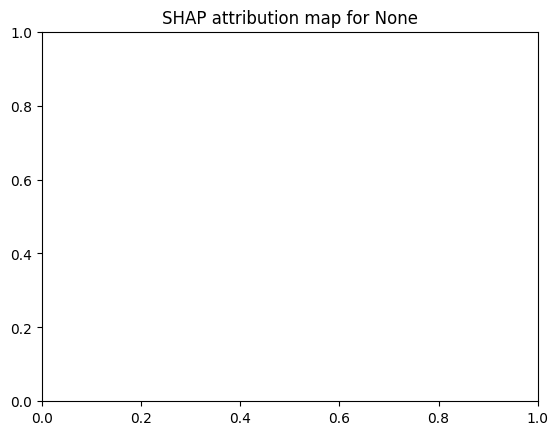

In [38]:
import pandas as pd
from collections import defaultdict
import os
import traceback

VERBOSE = 1 
DISPLAY_PLOTS = False
EXPORT_PLOTS = True
CHUNK_SIZE = 1  # nr of rows to process at a time
START_INDEX = 3  # default start index is 0

output = defaultdict(list)

# find total number of chunks needed
total_rows = len(stimuli_df)
num_chunks = (total_rows - START_INDEX) // CHUNK_SIZE + ((total_rows - START_INDEX) % CHUNK_SIZE > 0)

all_dfs = []  # list to store each chunk's DF

# loop through DF one chunk at a time
for chunk_start in range(START_INDEX, total_rows, CHUNK_SIZE):
    chunk_end = min(chunk_start + CHUNK_SIZE, total_rows)
    print(f"Processing rows {chunk_start} to {chunk_end} out of {total_rows}")

    # chunk output is a separate list
    chunk_output = defaultdict(list)

    # iterate through rows in chunk
    for index, row in stimuli_df.iloc[chunk_start:chunk_end].iterrows():
        print(f"Processing stimulus {index + 1} out of {total_rows}")

        # Copy main characteristics
        for name in ["img_path", "caption", "foil", "linguistic_phenomena"]:
            chunk_output[name].append(row[name])

        # Calculate shap map
        try:
            shap_map, n_variants = shap_functions.generate_shap(row['img_path'], row['caption'], row['foil'],
                                                                prediction_function=model_shap_predict,
                                                                model=None,
                                                                model_name=model_name,
                                                                verbose=VERBOSE,
                                                                plots=DISPLAY_PLOTS,
                                                                export_plots=EXPORT_PLOTS,
                                                                return_variant_count=True)
            chunk_output["model_shap_map"].append(shap_map)
            chunk_output['n_image_variants'].append(n_variants)

        except Exception as e:
            traceback.print_exc()
            chunk_output['model_shap_map'].append(f"Error: {str(e)}")
            chunk_output['n_image_variants'].append("Error")


    # convert the chunk output to a DF and save it
    chunk_df = pd.DataFrame.from_dict(chunk_output)
    chunk_df.to_pickle(f"xai_output/{model_name}_shap_maps_chunk_{chunk_start//CHUNK_SIZE}.pickle")

    

In [40]:
# merge all chunk outputs into one

# open aeach chunk DF, into a list
all_dfs = [pd.read_pickle(os.path.join("xai_output", filename)) for filename in os.listdir("xai_output") if "chunk" in filename and model_name in filename]

# merge all the lists
final_model_shap_df = pd.concat(all_dfs, ignore_index=True)
final_model_shap_df.to_pickle(f"xai_output/{model_name}_shap_maps.pickle")

In [32]:
final_model_shap_df

,img_path,caption,foil,linguistic_phenomena,model_shap_map
0,../../VALSE_data/images/swig/shopping_215.jpg,A woman shops at a grocery store.,A woman winks at a grocery store.,actions,Error: cannot resize an array that references ...
1,../../VALSE_data/images/swig/frisking_20.jpg,A policeman frisks a man.,A man frisks a policeman.,actions,Error: cannot resize an array that references ...
2,../../VALSE_data/images/swig/instructing_116.jpg,A woman instructs people.,The people instruct the woman.,actions,Error: cannot resize an array that references ...
3,../../VALSE_data/images/swig/subduing_201.jpg,A policeman subdues a man.,A man subdues a policeman.,actions,Error: cannot resize an array that references ...
4,../../VALSE_data/images/swig/scolding_34.jpg,A mother scolds her daughter.,A mother encourages her daughter.,actions,Error: cannot resize an array that references ...
...,...,...,...,...,...
94,../../VALSE_data/images/coco2017/000000488385.jpg,A black and white motorcycle parked on the sid...,A black and white motorcycle parked on the sid...,relations,Error: cannot resize an array that references ...
95,../../VALSE_data/images/coco2017/000000389684.jpg,a man walks down a sidewalk as a vehicle passes,A man walks up a sidewalk as a vehicle passes,relations,Error: cannot resize an array that references ...
96,../../VALSE_data/images/coco2017/000000121506.jpg,An umbrella on a backyard patio is upturned fr...,An umbrella on a backyard patio is upturned in...,relations,Error: cannot resize an array that references ...
97,../../VALSE_data/images/coco2017/000000378673.jpg,A man riding a skateboard down the side of a r...,A man riding a skateboard up the side of a ramp.,relations,Error: cannot resize an array that references ...


In [ ]:
for key in output.keys():
    print(key, len(output[key]))

img_path 2
caption 2
foil 2
linguistic_phenomena 2
model_shap_map 2


### Export resulting dataframe

In [ ]:
final_model_shap_df.to_pickle(f"xai_output/{model_name}_shap_maps.pickle")

### Find which if any stimuli threw an error

In [ ]:
final_model_shap_df[final_model_shap_df['model_shap_map'].apply(isinstance, args=(str,))]

,img_path,caption,foil,linguistic_phenomena,model_shap_map


In [ ]:
plt.imshow(final_clip_shap_df['clip_shap_map'][0])

NameError: name 'final_clip_shap_df' is not defined

In [21]:
import shutil
[shutil.copy(file_path, "images") for file_path in stimuli_df['img_path']]

['images/v7w_2318073.jpg',
 'images/v7w_2323857.jpg',
 'images/v7w_2336798.jpg',
 'images/v7w_2349587.jpg',
 'images/v7w_2352298.jpg',
 'images/v7w_2360434.jpg',
 'images/v7w_2362476.jpg',
 'images/v7w_2389519.jpg',
 'images/v7w_2393355.jpg',
 'images/v7w_2411942.jpg',
 'images/v7w_2417412.jpg',
 'images/speaking_84.jpg',
 'images/tripping_125.jpg',
 'images/punching_28.jpg',
 'images/handcuffing_40.jpg',
 'images/caressing_51.jpg',
 'images/urinating_251.jpg',
 'images/foraging_17.jpg',
 'images/communicating_34.jpg',
 'images/complaining_6.jpg',
 'images/counting_103.jpg',
 'images/socializing_108.jpg',
 'images/000000005529.jpg',
 'images/000000478393.jpg',
 'images/000000033368.jpg',
 'images/000000089880.jpg',
 'images/000000057027.jpg',
 'images/000000493019.jpg',
 'images/000000488385.jpg',
 'images/000000389684.jpg',
 'images/000000121506.jpg',
 'images/000000378673.jpg',
 'images/000000411953.jpg',
 'images/v7w_2331050.jpg',
 'images/v7w_2335370.jpg',
 'images/v7w_2342550.jpg'